# Анализ данных продажи билетов на мероприятия через сервис Яндекс Афиша

- Автор: Матвеева Анна
- Дата: Май 2025

## Цели и задачи проекта
Цель:

Провести исследовательскую работу поведения пользователей, выявить причинно-следственные связи и сделать выводы об изменении пользовательских предпочтений и популярности событий осенью 2024 года, а также проверить гипотезы о разнице в поведении пользователей с мобильных и стационарных устройств. 

Задача:

Провести исследовательский анализ данных и дать ответы на вопросы:
-	Сработал фактор сезонности и пользователи поменяли предпочтения? 
-	Изменилась ли аудитория? 
-	Какие события стали привлекать больше зрителей? 
-	Какие организаторы и площадки выбились в лидеры. 
-	Отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.

## Описание данных

Данные о бронировании билетов на сервисе Яндекс Афиша за период **с 1 июня по 30 октября 2024 года** представлены двумя датасетами:
- ` final_tickets_orders_df.csv `;
- ` final_tickets_events_df.csv`.

Первый датасет `final_tickets_orders_df.csv` включает информацию обо всех заказах билетов, совершённых с двух типов устройств — мобильных и стационарных. Поля датасета:

-	order_id — уникальный идентификатор заказа.
-	user_id — уникальный идентификатор пользователя.
-	created_dt_msk — дата создания заказа (московское время).
-	created_ts_msk — дата и время создания заказа (московское время).
-	event_id — идентификатор мероприятия из таблицы events.
-	cinema_circuit — сеть кинотеатров. Если не применимо, то здесь будет значение 'нет'.
-	age_limit — возрастное ограничение мероприятия.
-	currency_code — валюта оплаты, например rub для российских рублей.
-	device_type_canonical — тип устройства, с которого был оформлен заказ, например mobile для мобильных устройств, desktop для стационарных.
-	revenue — выручка от заказа.
-	service_name — название билетного оператора.
-	tickets_count — количество купленных билетов.
-	total — общая сумма заказа.
-	days_since_prev - количество дней с предыдущей покупки для каждого пользователя. Если покупки не было, то данные содержат пропуск.

Второй датасет `final_tickets_events_df.csv` содержит информацию о событиях, включая город и регион события, а также информацию о площадке проведения мероприятия. Из данных исключены фильмы, т.к. событий такого типа не так много. Датасет содержит такие поля:

-	event_id — уникальный идентификатор мероприятия.
-	event_name — название мероприятия. Аналог поля event_name_code из исходной базы данных.
-	event_type_description — описание типа мероприятия.
-	event_type_main — основной тип мероприятия: театральная постановка, концерт и так далее.
-	organizers — организаторы мероприятия.
-	region_name — название региона.
-	city_name — название города.
-	venue_id — уникальный идентификатор площадки.
-	venue_name — название площадки.
-	venue_address — адрес площадки.

Вспомогательный датасет `final_tickets_tenge_df.csv` с информацией о курсе тенге к российскому рублю за 2024 год. Значения в рублях представлено для 100 тенге. Датасет содержит такие поля:

-	nominal — номинал (100 тенге).
-	data — дата.
-	curs — курс тенге к рублю.
-	cdx — обозначение валюты (kzt).


## Содержимое проекта (основные шаги)

1. Загрузка данных и знакомство с ними.
2. Предобработка данных и подготовка их к исследованию
3. Исследовательский анализ данных.
    1. Анализ распределения заказов по сегментам и их сезонные изменения.
    2. Осенняя активность пользователей.
    3. Популярные события и партнёры.       
4. Статистический анализ данных
5. Итоговые выводы и рекомендации.

## 1. Загрузка данных и знакомство с ними

In [1]:
# Импортируем требуемые библиотеки
import os
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy import stats
import numpy as np
from scipy.stats import mannwhitneyu

In [2]:
# Считаем в датафреймы CSV-файлы с историческими данными
pth1 = '/datasets/final_tickets_orders_df.csv' # информация обо всех заказах билетов
pth2 = '/datasets/final_tickets_events_df.csv' # информация о событиях, городе, регионе и о площадке проведения мероприятия
pth3 = '/datasets/final_tickets_tenge_df.csv' # с информация о курсе тенге к российскому рублю за 2024 год

if os.path.exists(pth1):
    # Указываем, что нужно распарсить даты в столбцах с названиями 'created_dt_msk', 'created_ts_msk'
    orders_df = pd.read_csv(pth1, parse_dates=['created_dt_msk', 'created_ts_msk'])
else:
    print('File not found')
    orders_df = None
    
if os.path.exists(pth2):
    events_df = pd.read_csv(pth2)
else:
    print('File not found')
    
if os.path.exists(pth3):
    # Указываем, что нужно распарсить даты в столбцах с названиями 'data'
    tenge_df = pd.read_csv(pth3, parse_dates=['data'])
else:
    print('File not found')
    tenge_df = None

In [3]:
# Выводим информацию о датафрейме
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290849 non-null  int64         
 1   user_id                290849 non-null  object        
 2   created_dt_msk         290849 non-null  datetime64[ns]
 3   created_ts_msk         290849 non-null  datetime64[ns]
 4   event_id               290849 non-null  int64         
 5   cinema_circuit         290849 non-null  object        
 6   age_limit              290849 non-null  int64         
 7   currency_code          290849 non-null  object        
 8   device_type_canonical  290849 non-null  object        
 9   revenue                290849 non-null  float64       
 10  service_name           290849 non-null  object        
 11  tickets_count          290849 non-null  int64         
 12  total                  290849 non-null  floa

In [4]:
# Выводим информацию о датафрейме
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [5]:
# Выводим информацию о датафрейме
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [6]:
# Выводим на экран первые пять строк датафрейма
tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [7]:
# Выводим на экран первые пять строк датафрейма
orders_df.head()

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


In [8]:
# Выводим на экран первые пять строк датафрейма
events_df.head()

,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


#### **Первичные выводы** 

Первый датасет `final_tickets_orders_df.csv` содержит 290 849 строк и 14 столбцов. 

Типы данных корректны. Имеется возможность снижения размерности количественных данных. Два поля преобразованы в тип дата на стадии загрузки:
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).

Второй датасет `final_tickets_events_df.csv` содержит 22 427 строк и 11 столбцов. Типы данных корректны. Имеется возможность снижения размерности количественных данных.

Вспомогательный датасет `final_tickets_tenge_df.csv` содержит 357 строк и 4 столбца. Типы данных корректны. Имеется возможность снижения размерности количественных данных.

## 2. Предобработка данных и подготовка их к исследованию

In [9]:
# Считаем пропуски в датафрейме
orders_df.isna().sum()

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

In [10]:
# Считаем пропуски в датафрейме
events_df.isna().sum()

event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

In [11]:
# Считаем пропуски в датафрейме
tenge_df.isna().sum()

data       0
nominal    0
curs       0
cdx        0
dtype: int64

#### **Промежуточный вывод (датасеты)** 

Первый датасет `final_tickets_orders_df.csv`. Пропуски в данных отсутствуют, кроме столбца `days_since_prev` - в нем 21 940 пропусков. Значит столько пользователей совершили первую покупку (предыдущей не было).

Второй датасет `final_tickets_events_df.csv`. Пропуски отсутствуют. 

Вспомогательный датасет `final_tickets_tenge_df.csv`. Пропуски отсутствуют.

Проведем анализ для **категориальных значений**.

In [12]:
# Проверяем уникальные значения в категориальных столбцах orders_df
for column in ['service_name', 'device_type_canonical','age_limit','currency_code']:
    display(f'Уникальные значения в столбце {column}:')
    display(orders_df[column].sort_values().unique())
    display()

'Уникальные значения в столбце service_name:'

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

'Уникальные значения в столбце device_type_canonical:'

array(['desktop', 'mobile'], dtype=object)

'Уникальные значения в столбце age_limit:'

array([ 0,  6, 12, 16, 18])

'Уникальные значения в столбце currency_code:'

array(['kzt', 'rub'], dtype=object)

In [13]:
# Заменяем пробелы на подчеркивания и приводим все буквы к нижнему регистру
modified_column = orders_df['service_name'].str.replace(' ', '_').str.lower()
orders_df['service_name'] = modified_column

# Выводим измененный DataFrame для проверки
print("Orders_df скорректированный:")
display(orders_df)

Orders_df скорректированный:


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,край_билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,мой_билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,за_билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,лови_билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,билеты_без_проблем,3,10695.43,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290844,368620,fffcd3dde79eb2c,2024-10-27,2024-10-27 18:00:57,33189,нет,6,rub,mobile,965.57,весь_в_билетах,4,9655.73,0.0
290845,368562,fffcd3dde79eb2c,2024-10-27,2024-10-27 17:53:53,33189,нет,6,rub,mobile,1448.36,весь_в_билетах,6,14483.60,0.0
290846,8473772,fffcd3dde79eb2c,2024-10-30,2024-10-30 13:37:43,205231,нет,16,rub,desktop,178.95,прачечная,2,4473.74,3.0
290847,5526067,fffeeb3c120cf0b,2024-09-24,2024-09-24 10:07:42,454526,нет,18,rub,desktop,661.53,билеты_без_проблем,2,6615.34,NaN


#### **Промежуточный вывод** 
В двух вышеперечисленных столбцах данные не требуют оптимизации и редактирования. Столбец service_name скорректирован (удалены пробелы, буквы приведены к единому строчному формату).

In [14]:
# Проверяем уникальные значения в категориальных столбцах events_df
for column in ['event_type_description', 'event_type_main','organizers']:
    display(f'Уникальные значения в столбце {column}:')
    display(events_df[column].sort_values().unique())
    display()

'Уникальные значения в столбце event_type_description:'

array(['балет', 'выставка', 'концерт', 'кукольный спектакль',
       'музыкальный спектакль', 'мюзикл', 'опера', 'оперетта', 'подарок',
       'рок-мюзикл', 'снегурочка', 'событие', 'спектакль', 'спорт',
       'спортивное мероприятие', 'фестиваль', 'цирковое шоу', 'шоу',
       'экскурсия', 'ёлка'], dtype=object)

'Уникальные значения в столбце event_type_main:'

array(['выставки', 'другое', 'концерты', 'спорт', 'стендап', 'театр',
       'ёлки'], dtype=object)

'Уникальные значения в столбце organizers:'

array(['№1000', '№1001', '№1002', ..., '№997', '№998', '№999'],
      dtype=object)

In [15]:
# Заменяем в текстовых столбцах пробелы на подчеркивания и приводим все буквы к нижнему регистру
modified_column = events_df['event_type_description'].str.replace(' ', '_').str.lower()
events_df['event_type_description'] = modified_column

modified_column = events_df['venue_name'].str.replace(' ', '_').str.lower()
events_df['venue_name'] = modified_column

modified_column = events_df['venue_address'].str.replace(' ', '_').str.lower()
events_df['venue_address'] = modified_column

modified_column = events_df['region_name'].str.replace(' ', '_').str.lower()
events_df['region_name'] = modified_column

# Выводим измененный DataFrame для проверки
print("Столбцы скорректированны:")
display(events_df)

Столбцы скорректированны:


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,североярская_область,Озёрск,2,1600,"кладбище_искусств_""проблема""_и_партнеры","наб._загородная,_д._785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,светополянский_округ,Глиноград,54,2196,"лекции_по_искусству_""свет""_групп","ул._ягодная,_д._942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,североярская_область,Озёрск,2,4043,"кинокомитет_""золотая""_инк","ш._коммуны,_д._92_стр._6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,каменевский_регион,Глиногорск,213,1987,"выставка_ремесел_""свет""_лтд","пер._набережный,_д._35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,лесодальний_край,Родниковец,55,4230,"фестивальный_проект_""листья""_групп","пер._проезжий,_д._9"
...,...,...,...,...,...,...,...,...,...,...,...
22422,591313,196f51a8-344a-462a-b806-a8467fd0e5fa,спортивное_мероприятие,спорт,№1623,речиновская_область,Дальнесветск,65,3721,"студия_графики_""оттенок""_инк","ул._чапаева,_д._8_стр._1/3"
22423,591859,b2b83233-f861-496c-b6fb-a4fef347deb1,ёлка,ёлки,№1992,солнечноземская_область,Глинополье,56,3005,"арт-кафе_""аксессуар""_лимитед","бул._логовой,_д._94_к._1/5"
22424,591877,6bffa2da-51d1-4cfe-accb-a02e617a8180,событие,другое,№1767,североключевской_округ,Ягодинска,21702,3506,"клуб_современных_танцев_""кофе""_групп","ш._тупиковое,_д._49_стр._73"
22425,592322,9283cb32-2750-43cd-b57e-dde9ccd5552e,событие,другое,№3884,яблоневская_область,Светополье,39,1081,"искусственная_сцена_""краски""_и_партнеры","пер._р.люксембург,_д._499_к._997"


В текстовых столбцах данные скорректированы (удалены пробелы, буквы приведены к единому строчному формату).

In [16]:
# Считаем количество уникальных комбинаций в столбцах Города
unique_group1_events_df = events_df[['region_name', 'city_name', 'city_id']].nunique()
print(f'Количество уникальных комбинаций Регион - Город:')
print(unique_group1_events_df)

Количество уникальных комбинаций Регион - Город:
region_name     81
city_name      352
city_id        353
dtype: int64


In [17]:
# Группируем данные по city_name и считаем количество уникальных city_id
grouped1 = events_df.groupby('city_name')['city_id'].nunique()

# Находим city_name, у которых более одного city_id
duplicate_cities_id = grouped1.loc[grouped1 > 1].reset_index()

# Выводим название города, у которого есть 2 и более city_id
print("Город с двумя и более city_id:")
display(duplicate_cities_id['city_name'])

Город с двумя и более city_id:


0    Глинополье
Name: city_name, dtype: object

In [18]:
# Фильтруем events_df, чтобы оставить только строки, где city_name равно 'Глинополье'
filtered_df = events_df[events_df['city_name'] == 'Глинополье']

# Создаем сводную таблицу
pivot_table = pd.pivot_table(filtered_df, 
                            values='city_id', 
                            index=['city_name', 'region_name'], 
                            aggfunc='sum')

# Выводим сводную таблицу
print("Сводная таблица city_id по city_name и region_name:")
display(pivot_table)

Сводная таблица city_id по city_name и region_name:


city_id
city_name  region_name                     
Глинополье голубевский_округ          22202
           солнечноземская_область    27776

В двух регионах имеется город с одинаковым названием

In [19]:
# Считаем количество уникальных комбинаций в столбцах Площадка
unique_group2_events_df = events_df[['venue_id', 'venue_name', 'venue_address']].nunique()
print(f'Количество уникальных комбинаций Площадка - Адрес:')
print(unique_group2_events_df)

Количество уникальных комбинаций Площадка - Адрес:
venue_id         3225
venue_name       3217
venue_address    3225
dtype: int64


In [20]:
# Группируем данные по venue_name и считаем количество уникальных venue_id
grouped = events_df.groupby('venue_name')['venue_id'].nunique()

# Находим venue_name, у которых более одного venue_id
duplicate_venues = grouped.loc[grouped > 1].reset_index()

# Выводим название площадки venue_name, у которой есть 2 и более venue_id
print("Площадки с двумя и более venue_id:")
display(duplicate_venues['venue_name'])

Площадки с двумя и более venue_id:


0                       арт-объединение_"сделайка"_инк
1              детская_художественная_школа_"echo"_инк
2    клуб_исторических_реконструкций_"палитра"_и_па...
3                    клуб_стендап-комедии_"символ"_лтд
4          мастерская_графического_дизайна_"успех"_лтд
5                     ремесленный_центр_"лестница"_лтд
6     санкт-петербургский_дом_культуры_"пегас"_лимитед
7            центр_традиционной_культуры_"стройка"_лтд
Name: venue_name, dtype: object

Среди площадок имеется 8 позиций, наименования которых повторяются при разных адресах и venue_id

In [21]:
# Проверяем период для столбца created_dt_msk
print(orders_df['created_dt_msk'].min())
print(orders_df['created_dt_msk'].max())

# Проверяем период для столбца created_ts_msk
print(orders_df['created_ts_msk'].min())
print(orders_df['created_ts_msk'].max())

2024-06-01 00:00:00
2024-10-31 00:00:00
2024-06-01 00:00:42
2024-10-31 23:59:54


В столбцах с датой период корректный, аномальных отклонений как минус, так и в плюс нет.

#### **Промежуточный вывод (катег. знач.)** 
В текстовых столбцах данные скорректированы (удалены пробелы, буквы приведены к единому строчному формату).

В двух регионах имеется город с одинаковым названием Глинополье.

Среди площадок имеется 8 позиций, наименования которых повторяются при разных адресах и venue_id.

В столбцах с датой период корректный, аномальных отклонений как минус, так и в плюс нет.

Проведем анализ **количественных значений** на распределение и наличие выбросов.

In [22]:
print('Анализ данных показателя выручка с заказа revenue в рублях:')
orders_df[orders_df['currency_code']=='rub']['revenue'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

Анализ данных показателя выручка с заказа revenue в рублях:


count    285780.000000
mean        547.568333
std         871.524559
min         -90.760000
5%           16.180000
25%         113.827500
50%         346.100000
75%         791.700000
95%        1606.500000
99%        2569.594200
max       81174.540000
Name: revenue, dtype: float64

In [23]:
print('Анализ данных показателя выручка с заказа revenue в тенге:')
orders_df[orders_df['currency_code']=='kzt']['revenue'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

Анализ данных показателя выручка с заказа revenue в тенге:


count     5069.000000
mean      4995.206767
std       4916.752776
min          0.000000
5%         164.390000
25%        518.100000
50%       3698.830000
75%       7397.660000
95%      13784.260000
99%      17617.240000
max      26425.860000
Name: revenue, dtype: float64

In [24]:
print('Анализ данных показателя количество билетов в заказе tickets_count в рублях:')
orders_df[orders_df['currency_code']=='rub']['tickets_count'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

Анализ данных показателя количество билетов в заказе tickets_count в рублях:


count    285780.000000
mean          2.754077
std           1.171419
min           1.000000
5%            1.000000
25%           2.000000
50%           3.000000
75%           4.000000
95%           5.000000
99%           6.000000
max          57.000000
Name: tickets_count, dtype: float64

In [25]:
print('Анализ данных показателя количество билетов в заказе tickets_count в тенге:')
orders_df[orders_df['currency_code']=='kzt']['tickets_count'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

Анализ данных показателя количество билетов в заказе tickets_count в тенге:


count    5069.000000
mean        2.762872
std         1.115558
min         1.000000
5%          1.000000
25%         2.000000
50%         3.000000
75%         4.000000
95%         5.000000
99%         6.000000
max         6.000000
Name: tickets_count, dtype: float64

#### **Промежуточный вывод** 

Анализ показал, что в заказах, оформленных в рублях, присутствуют аномальные значения. Имеется ряд возвратов, т.к. min значение равно -90.76 руб., а так же, видимо, разовая акция покупки 57 билетов и покупки на максимальную сумму 81 174.54 руб. В тенге аномалий нет.

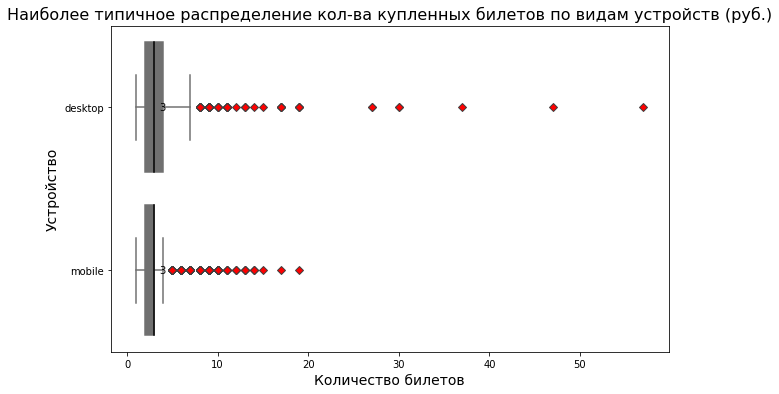

In [26]:
# Отобразим данные с аномальными значениями по количеству купленных билетов
# Фильтруем данные, оставляя только записи в рублях
filtered_orders_rub = orders_df[orders_df['currency_code']=='rub'].copy()

# Вычисляем медиану для каждого девайса
median_seats = filtered_orders_rub.groupby('device_type_canonical')['tickets_count'].median().reset_index()

# Сортируем категории по медиане в порядке убывания
sorted_categories = median_seats.sort_values('tickets_count', ascending=False)['device_type_canonical']

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Определяем единый цвет для всех элементов
box_color = '#707070'

# Строим диаграмму размаха значений в столбце seats
sns.boxplot(x=filtered_orders_rub['tickets_count'],
            y=filtered_orders_rub['device_type_canonical'],
            order=sorted_categories,
            flierprops=dict(markerfacecolor='r', marker='D'),
            boxprops={'color': box_color},
            whiskerprops={'color': box_color},
            medianprops={'color': '#000000'},
            capprops={'color': box_color},
            saturation=10)  # насыщенность цвета

for i, category in enumerate(sorted_categories):
    median_value = median_seats.loc[median_seats['device_type_canonical'] == category, 'tickets_count'].values[0]
    plt.text(median_value + 0.5, i, f'{median_value:.0f}', ha='left', va='center', color='black', fontsize=10)

# Добавляем заголовок и метки осей
plt.title('Наиболее типичное распределение кол-ва купленных билетов по видам устройств (руб.)',fontsize=16,)
plt.xlabel('Количество билетов',fontsize=14,)
plt.ylabel('Устройство',fontsize=14,)

# Выводим график
plt.show()

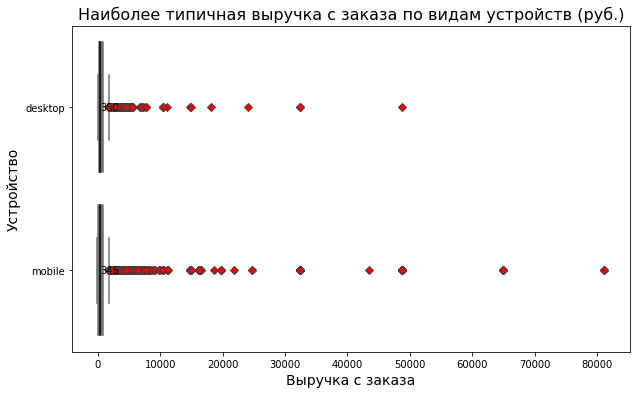

In [27]:
# Отобразим данные с аномальными значениями по выручке с заказа
# Фильтруем данные, оставляя только записи в рублях
filtered_orders_rub = orders_df[orders_df['currency_code']=='rub'].copy()

# Вычисляем медиану для каждого девайса
median_seats = filtered_orders_rub.groupby('device_type_canonical')['revenue'].median().reset_index()

# Сортируем категории по медиане в порядке убывания
sorted_categories = median_seats.sort_values('revenue', ascending=False)['device_type_canonical']

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Определяем единый цвет для всех элементов
box_color = '#707070'

# Строим диаграмму размаха значений в столбце seats
sns.boxplot(x=filtered_orders_rub['revenue'],
            y=filtered_orders_rub['device_type_canonical'],
            order=sorted_categories,
            flierprops=dict(markerfacecolor='r', marker='D'),
            boxprops={'color': box_color},
            whiskerprops={'color': box_color},
            medianprops={'color': '#000000'},
            capprops={'color': box_color},
            saturation=10)  # насыщенность цвета

for i, category in enumerate(sorted_categories):
    median_value = median_seats.loc[median_seats['device_type_canonical'] == category, 'revenue'].values[0]
    plt.text(median_value + 0.5, i, f'{median_value:.0f}', ha='left', va='center', color='black', fontsize=10)

# Добавляем заголовок и метки осей
plt.title('Наиболее типичная выручка с заказа по видам устройств (руб.)',fontsize=16,)
plt.xlabel('Выручка с заказа',fontsize=14,)
plt.ylabel('Устройство',fontsize=14,)

# Выводим график
plt.show()

Выбросы ярко выражены на диаграммах размаха.

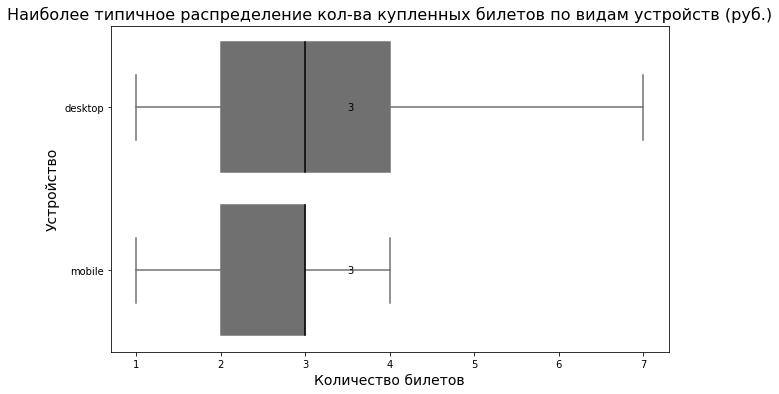

In [28]:
# Отобразим данные БЕЗ аномальных значениями по количеству купленных билетов
# Фильтруем данные, оставляя только записи в рублях
filtered_orders_rub = orders_df[orders_df['currency_code']=='rub'].copy()

# Вычисляем медиану для каждого девайса
median_seats = filtered_orders_rub.groupby('device_type_canonical')['tickets_count'].median().reset_index()

# Сортируем категории по медиане в порядке убывания
sorted_categories = median_seats.sort_values('tickets_count', ascending=False)['device_type_canonical']

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Определяем единый цвет для всех элементов
box_color = '#707070'

# Строим диаграмму размаха значений в столбце seats
sns.boxplot(x=filtered_orders_rub['tickets_count'],
            y=filtered_orders_rub['device_type_canonical'],
            order=sorted_categories,
            showfliers=False,
            flierprops=dict(markerfacecolor='r', marker='D'),
            boxprops={'color': box_color},
            whiskerprops={'color': box_color},
            medianprops={'color': '#000000'},
            capprops={'color': box_color},
            saturation=10)  # насыщенность цвета

for i, category in enumerate(sorted_categories):
    median_value = median_seats.loc[median_seats['device_type_canonical'] == category, 'tickets_count'].values[0]
    plt.text(median_value + 0.5, i, f'{median_value:.0f}', ha='left', va='center', color='black', fontsize=10)

# Добавляем заголовок и метки осей
plt.title('Наиболее типичное распределение кол-ва купленных билетов по видам устройств (руб.)',fontsize=16,)
plt.xlabel('Количество билетов',fontsize=14,)
plt.ylabel('Устройство',fontsize=14,)

# Выводим график
plt.show()

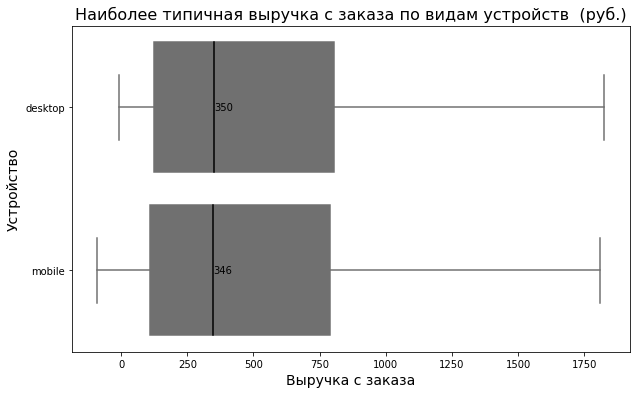

In [29]:
# Отобразим данные с аномальными значениями по выручке с заказа
# Фильтруем данные, оставляя только записи в рублях
filtered_orders_rub = orders_df[orders_df['currency_code']=='rub'].copy()

# Вычисляем медиану для каждого девайса
median_seats = filtered_orders_rub.groupby('device_type_canonical')['revenue'].median().reset_index()

# Сортируем категории по медиане в порядке убывания
sorted_categories = median_seats.sort_values('revenue', ascending=False)['device_type_canonical']

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(10, 6))

# Определяем единый цвет для всех элементов
box_color = '#707070'

# Строим диаграмму размаха значений в столбце seats
sns.boxplot(x=filtered_orders_rub['revenue'],
            y=filtered_orders_rub['device_type_canonical'],
            order=sorted_categories,
            showfliers=False,
            flierprops=dict(markerfacecolor='r', marker='D'),
            boxprops={'color': box_color},
            whiskerprops={'color': box_color},
            medianprops={'color': '#000000'},
            capprops={'color': box_color},
            saturation=10)  # насыщенность цвета

for i, category in enumerate(sorted_categories):
    median_value = median_seats.loc[median_seats['device_type_canonical'] == category, 'revenue'].values[0]
    plt.text(median_value + 0.5, i, f'{median_value:.0f}', ha='left', va='center', color='black', fontsize=10)

# Добавляем заголовок и метки осей
plt.title('Наиболее типичная выручка с заказа по видам устройств  (руб.)',fontsize=16,)
plt.xlabel('Выручка с заказа',fontsize=14,)
plt.ylabel('Устройство',fontsize=14,)

# Выводим график
plt.show()

Теперь видно, что кол-во купленных билетов и выручка с заказа не сильно отличаются при оформлении с различных устройств.

'99% - 2569.59 руб.'

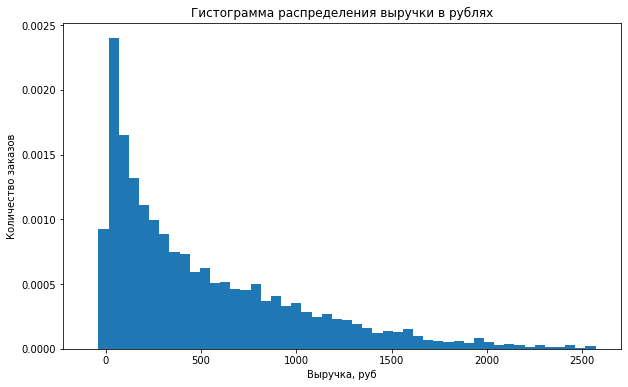

In [30]:
# Находим 99-й процентиль выручки в рублях (т.к. есть выбросы)
revenue_percentile = orders_df[orders_df['currency_code']=='rub']['revenue'].quantile(0.99)
display(f'99% - {round(revenue_percentile,2)} руб.')

# Фильтруем строки с выручкой в рублях и ниже 99-го процентиля
filtered_orders_rub = orders_df[orders_df['currency_code']=='rub'].copy()
high_revenue_orders = filtered_orders_rub[filtered_orders_rub['revenue'] <= revenue_percentile].copy()

# Строим гистограмму распределения выручки
plt.figure(figsize=(10, 6))
plt.title('Гистограмма распределения выручки в рублях')
plt.xlabel('Выручка, руб')
plt.ylabel('Количество заказов')
plt.hist(high_revenue_orders['revenue'], bins=50, density=True)
plt.show()

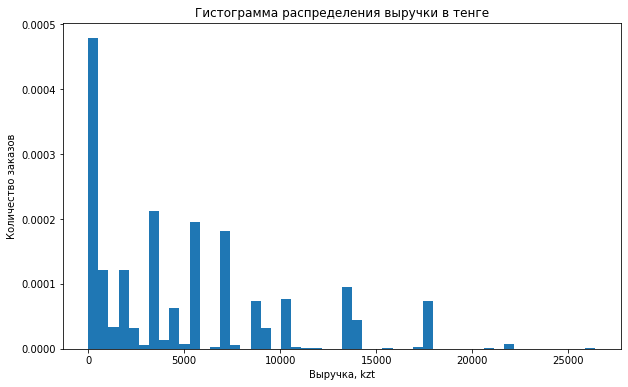

In [31]:
# Фильтруем строки с выручкой в тенге
filtered_orders_kzt = orders_df[orders_df['currency_code']=='kzt'].copy()

# Строим гистограмму распределения выручки
plt.figure(figsize=(10, 6))
plt.title('Гистограмма распределения выручки в тенге')
plt.xlabel('Выручка, kzt')
plt.ylabel('Количество заказов')
plt.hist(filtered_orders_kzt['revenue'], bins=50, density=True)
plt.show()

#### **Промежуточный вывод (кол.знач.)** 

Анализ заказов в рублях показал, что в заказах присутствуют аномальные значения. Имеется ряд возвратов, т.к. min значение равно -90.76 руб., а так же, видимо, разовая акция покупки 57 билетов и покупки на максимальную сумму 81 174.54 руб. В тенге аномалий нет.

Если исключить аномальные значения, кол-во купленных билетов и выручка с заказа, оформленного в рублях, не сильно отличаются при оформлении с различных устройств.

**Проверяем явные и неявные дубликаты. Акцент на неявных дубликатах по бронированию билета без учёта идентификаторов заказа.**

In [32]:
# Проверяем наличие ЯВНЫХ дубликатов
display("Явные дубликаты по orders", orders_df.duplicated().sum())
display("Явные дубликаты по events", events_df.duplicated().sum())

'Явные дубликаты по orders'

0

'Явные дубликаты по events'

0

In [33]:
# Проверяем наличие НЕявных дубликатов orders_df

# Исключаем столбец order_id из проверки на дубликаты
columns_to_check = orders_df.columns.drop('order_id').copy()

# Проверяем неявные дубликаты по всем указанным столбцам
duplicate_rows = orders_df[columns_to_check].duplicated()

# Подсчет количества дубликатов
duplicate_count = duplicate_rows.value_counts()

# Вывод количества дубликатов
print("Количество неявных дубликатов orders_df:")
print(duplicate_count)

# Выводим строки с дубликатами
# display(orders_df[duplicate_rows].sort_values('order_id'))

Количество неявных дубликатов orders_df:
False    290819
True         30
dtype: int64


#### **Промежуточный вывод (дубликаты)** 

Анализ показал наличие 30 строк с неявными дубликатами по бронированию билетов в рублях. Данные строки удаляем из датафрейма.

In [34]:
# Находим индексы строк с дубликатами
duplicate_index = duplicate_rows.index[duplicate_rows].tolist()
# Удаляем дубликаты
orders_df.drop(orders_df.index[duplicate_index], inplace=True)

In [35]:
# Выводим информацию о датафрейме
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290819 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290819 non-null  int64         
 1   user_id                290819 non-null  object        
 2   created_dt_msk         290819 non-null  datetime64[ns]
 3   created_ts_msk         290819 non-null  datetime64[ns]
 4   event_id               290819 non-null  int64         
 5   cinema_circuit         290819 non-null  object        
 6   age_limit              290819 non-null  int64         
 7   currency_code          290819 non-null  object        
 8   device_type_canonical  290819 non-null  object        
 9   revenue                290819 non-null  float64       
 10  service_name           290819 non-null  object        
 11  tickets_count          290819 non-null  int64         
 12  total                  290819 non-null  floa

In [37]:
# Оптимизируем столбец хранящий уникальный идентификатор
orders_df['order_id'] = pd.to_numeric(orders_df['order_id'], downcast='integer')
# Оптимизируем столбец хранящий только возраст
orders_df['age_limit'] = pd.to_numeric(orders_df['age_limit'], downcast='integer')
# Оптимизируем столбец хранящий только кол-во купленных билетов
orders_df['tickets_count'] = pd.to_numeric(orders_df['tickets_count'], downcast='integer')
# Оптимизируем тип данных с кол-ом дней
orders_df['days_since_prev'] = pd.to_numeric(orders_df['days_since_prev'], downcast='float')

In [38]:
# Выводим информацию о датафрейме
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290819 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   order_id               290819 non-null  int32         
 1   user_id                290819 non-null  object        
 2   created_dt_msk         290819 non-null  datetime64[ns]
 3   created_ts_msk         290819 non-null  datetime64[ns]
 4   event_id               290819 non-null  int64         
 5   cinema_circuit         290819 non-null  object        
 6   age_limit              290819 non-null  int8          
 7   currency_code          290819 non-null  object        
 8   device_type_canonical  290819 non-null  object        
 9   revenue                290819 non-null  float64       
 10  service_name           290819 non-null  object        
 11  tickets_count          290819 non-null  int8          
 12  total                  290819 non-null  floa

In [39]:
# Выводим информацию о датафрейме
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int64 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int64 
 8   venue_id                22427 non-null  int64 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.9+ MB


In [40]:
# Оптимизируем столбцы с уникальными идентификаторами
events_df['city_id'] = pd.to_numeric(events_df['city_id'], downcast='integer')
events_df['venue_id'] = pd.to_numeric(events_df['venue_id'], downcast='integer')
events_df['event_id'] = pd.to_numeric(events_df['event_id'], downcast='integer')

In [41]:
# Выводим информацию о датафрейме
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22427 entries, 0 to 22426
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   event_id                22427 non-null  int32 
 1   event_name              22427 non-null  object
 2   event_type_description  22427 non-null  object
 3   event_type_main         22427 non-null  object
 4   organizers              22427 non-null  object
 5   region_name             22427 non-null  object
 6   city_name               22427 non-null  object
 7   city_id                 22427 non-null  int32 
 8   venue_id                22427 non-null  int16 
 9   venue_name              22427 non-null  object
 10  venue_address           22427 non-null  object
dtypes: int16(1), int32(2), object(8)
memory usage: 1.6+ MB


In [42]:
# Выводим информацию о датафрейме
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


In [43]:
# Оптимизируем столбец хранящий только 1 значение
tenge_df['nominal'] = pd.to_numeric(tenge_df['nominal'], downcast='integer')
# Оптимизируем тип данных с курсом 
tenge_df['curs'] = pd.to_numeric(tenge_df['curs'], downcast='float')

In [44]:
# Выводим информацию о датафрейме
tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int8          
 2   curs     357 non-null    float32       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float32(1), int8(1), object(1)
memory usage: 7.4+ KB


#### **Промежуточный вывод (типы данных и пропуски)** 

Проведена работа по преобразованию типов данных на предмет снижения размерности количественных данных.

Сформируем единый датафрейм со всеми необходимыми для дальнейшего анализа столбцами:

In [45]:
# Объединим датафреймы по дате
merged_df_2 = pd.merge(
    orders_df, # Заказы
    tenge_df, # курс валюты
    left_on='created_dt_msk',
    right_on='data',
    how='left'
)

# Расчет revenue_rub с условием по валюте
merged_df_2['revenue_rub'] = merged_df_2.apply(
    lambda row: (
        row['revenue']  # если валюта RUB
        if row['currency_code'] == 'rub' 
        else row['revenue'] * (row['curs'] / 100)  # если KZT (курс для 100 тенге)
    ),
    axis=1
)

# Расчет total_rub с условием по валюте
merged_df_2['total_rub'] = merged_df_2.apply(
    lambda row: (
        row['total']  # если валюта RUB
        if row['currency_code'] == 'rub' 
        else row['total'] * (row['curs'] / 100)  # если KZT (курс для 100 тенге)
    ),
    axis=1
)

# Расчет выручки на билет
merged_df_2['one_ticket_revenue_rub'] = merged_df_2['revenue_rub'] / merged_df_2['tickets_count']

# Расчет цены 1 билета в рублях
merged_df_2['price_one_ticket'] = merged_df_2['total_rub'] / merged_df_2['tickets_count']

# Месяц и сезон
merged_df_2['month'] = merged_df_2['created_dt_msk'].dt.month
merged_df_2['season'] = merged_df_2['month'].apply(
    lambda m: 'зима' if m in [12, 1, 2] else 'весна' if m in [3,4,5] else 'лето' if m in [6,7,8] else 'осень'
)

In [46]:
# Проверка результата
display(merged_df_2[['event_id', 'created_dt_msk','currency_code', 'revenue', 'curs','revenue_rub','tickets_count', 'total','total_rub','one_ticket_revenue_rub','season']].head(100))

,event_id,created_dt_msk,currency_code,revenue,curs,revenue_rub,tickets_count,total,total_rub,one_ticket_revenue_rub,season
0,169230,2024-08-20,rub,1521.94,18.697201,1521.940000,4,10870.99,10870.990000,380.485000,лето
1,237325,2024-07-23,rub,289.45,18.341900,289.450000,2,2067.51,2067.510000,144.725000,лето
2,578454,2024-10-06,rub,1258.57,19.647499,1258.570000,4,13984.16,13984.160000,314.642500,осень
3,387271,2024-07-13,rub,8.49,18.500999,8.490000,2,212.28,212.280000,4.245000,лето
4,509453,2024-10-04,rub,1390.41,19.664801,1390.410000,3,10695.43,10695.430000,463.470000,осень
...,...,...,...,...,...,...,...,...,...,...,...
95,210886,2024-10-26,rub,239.53,19.926600,239.530000,3,2994.08,2994.080000,79.843333,осень
96,210886,2024-10-26,rub,159.68,19.926600,159.680000,2,1996.05,1996.050000,79.840000,осень
97,434092,2024-10-18,rub,594.55,19.869699,594.550000,2,4954.58,4954.580000,297.275000,осень
98,317069,2024-07-21,rub,47.56,18.451799,47.560000,2,951.10,951.100000,23.780000,лето


In [47]:
# Объединим датафреймы 
merged_df_3 = pd.merge(
    merged_df_2, # Заказы + курс валют
    events_df, # События
    left_on='event_id',
    right_on='event_id',
    how='inner'
)

In [48]:
merged_df_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290581 entries, 0 to 290580
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290581 non-null  int32         
 1   user_id                 290581 non-null  object        
 2   created_dt_msk          290581 non-null  datetime64[ns]
 3   created_ts_msk          290581 non-null  datetime64[ns]
 4   event_id                290581 non-null  int64         
 5   cinema_circuit          290581 non-null  object        
 6   age_limit               290581 non-null  int8          
 7   currency_code           290581 non-null  object        
 8   device_type_canonical   290581 non-null  object        
 9   revenue                 290581 non-null  float64       
 10  service_name            290581 non-null  object        
 11  tickets_count           290581 non-null  int8          
 12  total                   290581

In [49]:
# Рассмотрим анализ столбца "Выручка в рублях"
merged_df_3['revenue_rub'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

count    290581.000000
mean        555.594726
std         875.529616
min         -90.760000
5%           16.840000
25%         113.970000
50%         351.140000
75%         802.050000
95%        1630.650000
99%        2628.421657
max       81174.540000
Name: revenue_rub, dtype: float64

In [50]:
# Оставляем в итоговом датасете только строки с выручкой в рублях ниже 99-го процентиля
revenue_percentile = merged_df_3['revenue_rub'].quantile(0.99)
merged_df = merged_df_3[merged_df_3['revenue_rub'] <= revenue_percentile].copy()
merged_df['revenue_rub'].describe(percentiles=[0.05,0.25,0.5,0.75,0.95,0.99])

count    287756.000000
mean        518.048273
std         511.968266
min         -90.760000
5%           16.575387
25%         111.860000
50%         343.955000
75%         788.660000
95%        1572.710000
99%        2156.080000
max        2628.421657
Name: revenue_rub, dtype: float64

#### **Промежуточный вывод (итоговый датафрейм)** 
Проведена работа по предобработке имеющихся данных.
Первый датасет final_tickets_orders_df.csv. Пропуски в данных отсутствуют, кроме столбца days_since_prev - в нем 21 940 пропусков. Значит столько пользователей совершили первую покупку (предыдущей не было).

Второй датасет final_tickets_events_df.csv. Пропуски отсутствуют.

Вспомогательный датасет final_tickets_tenge_df.csv. Пропуски отсутствуют.

В большинстве столбцов данные не требуют оптимизации и редактирования. 

В нескольких текстовых столбцах данные скорректированы (удалены пробелы, буквы приведены к единому строчному формату).

В двух регионах имеется город с одинаковым названием Глинополье.

Среди площадок имеется 8 позиций, наименования которых повторяются при разных адресах и venue_id.

В столбцах с датой период корректный, аномальных отклонений как минус, так и в плюс нет.

Анализ заказов в рублях показал, что в заказах присутствуют аномальные значения. Имеется ряд возвратов, т.к. min значение равно -90.76 руб., а так же, видимо, разовая акция покупки 57 билетов и покупки на максимальную сумму 81 174.54 руб. В тенге аномалий нет.

Проведена работа по преобразованию типов данных на предмет снижения размерности количественных данных.

Анализ показал наличие 30 строк с неявными дубликатами по бронированию билетов в рублях. Данные строки удаляем из датафрейма.

В итоге сформирован объединенный из 3х датафрейм - merged_df - со столбцом по выручке в рублях, ценой 1 билета в рублях, временем года, не имеющий выбросов.

## 3. Исследовательский анализ данных

### 3.1. Анализ распределения заказов по сегментам и их сезонные изменения

,created_dt_msk,orders_count,month
0,2024-06-30,33903,June
1,2024-07-31,40452,July
2,2024-08-31,44573,August
3,2024-09-30,69415,September
4,2024-10-31,99413,October


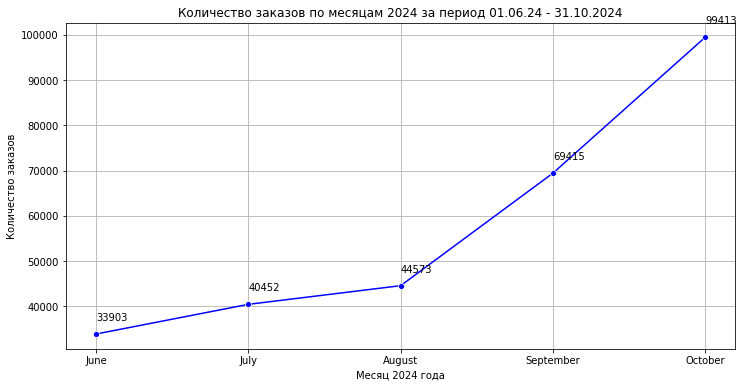

In [51]:
# Группировка по месяцам
monthly_orders = merged_df.resample('M', on='created_dt_msk').size().reset_index(name='orders_count')
# Преобразуем столбец 'created_dt_msk' в строковый формат, содержащий названия месяцев
monthly_orders['month'] = monthly_orders['created_dt_msk'].dt.to_period('M').dt.strftime('%B')
display(monthly_orders)

# Визуализация
plt.figure(figsize=(12, 6))
sns.lineplot(data = monthly_orders, x='month', y='orders_count', marker='o', color='blue')

# Добавляем подписи значений на графике
for month, count in zip(monthly_orders['month'], monthly_orders['orders_count']):
    plt.text(x=month, y=count + 3000, s=count, fontsize=10, color='black')

plt.title('Количество заказов по месяцам 2024 за период 01.06.24 - 31.10.2024')
plt.xlabel('Месяц 2024 года')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

#### С июня по ноябрь заказы выросли почти в 3 раза.

In [52]:
# Фильтрация данных по сезонам
summer_data = merged_df[merged_df['season'] == 'лето'].copy()
autumn_data = merged_df[merged_df['season'] == 'осень'].copy()

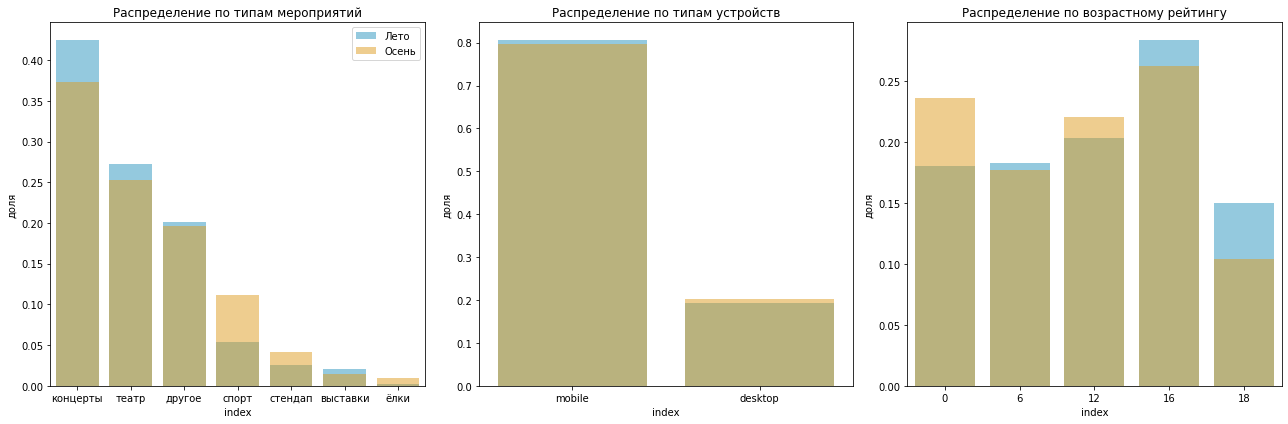

In [53]:
# Функция для расчета долей
def get_category_distribution(data, category_col):
    return data[category_col].value_counts(normalize=True).reset_index(name='доля')

# Сравнение по типам мероприятий
event_type_summer = get_category_distribution(summer_data, 'event_type_main')
event_type_autumn = get_category_distribution(autumn_data, 'event_type_main')

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Тип мероприятия
sns.barplot(data=event_type_summer, x='index', y='доля', ax=axes[0], color='skyblue', label='Лето')
sns.barplot(data=event_type_autumn, x='index', y='доля', ax=axes[0], color='orange', alpha=0.5, label='Осень')
axes[0].set_title('Распределение по типам мероприятий')
axes[0].legend()

# Тип устройства
device_summer = get_category_distribution(summer_data, 'device_type_canonical')
device_autumn = get_category_distribution(autumn_data, 'device_type_canonical')
sns.barplot(data=device_summer, x='index', y='доля', ax=axes[1], color='skyblue', label='Лето')
sns.barplot(data=device_autumn, x='index', y='доля', ax=axes[1], color='orange', alpha=0.5, label='Осень')
axes[1].set_title('Распределение по типам устройств')

# Возрастной рейтинг
age_summer = get_category_distribution(summer_data, 'age_limit')
age_autumn = get_category_distribution(autumn_data, 'age_limit')
sns.barplot(data=age_summer, x='index', y='доля', ax=axes[2], color='skyblue', label='Лето')
sns.barplot(data=age_autumn, x='index', y='доля', ax=axes[2], color='orange', alpha=0.5, label='Осень')
axes[2].set_title('Распределение по возрастному рейтингу')

plt.tight_layout()
plt.show()

#### Из графиков выше видно, что:
- Летом преобладают концерты и театры, а осенью — спорт и стендап. Ярко выражены отличия по концертам и спорту. 
- Устройства используются практически одинаково, мобильные устройства чуть чаще летом, а стационарные - осенью.
- Посещение мероприятий в возрасте 6 и 12 лет практически одинаково в оба сезона. Однако, 16+, 18+ чаще покупают билеты летом, а 0+ - осенью.

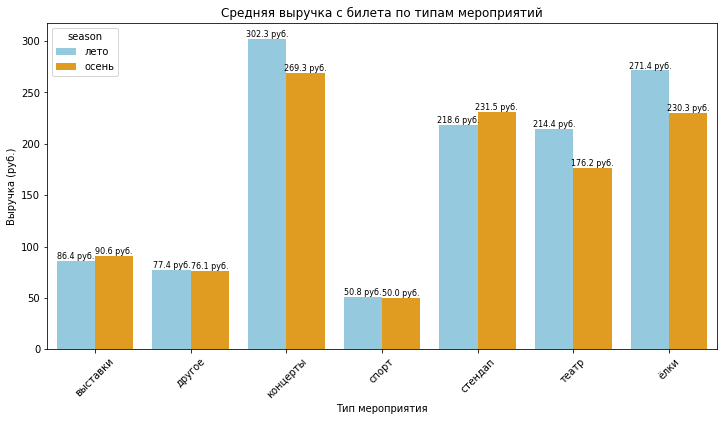

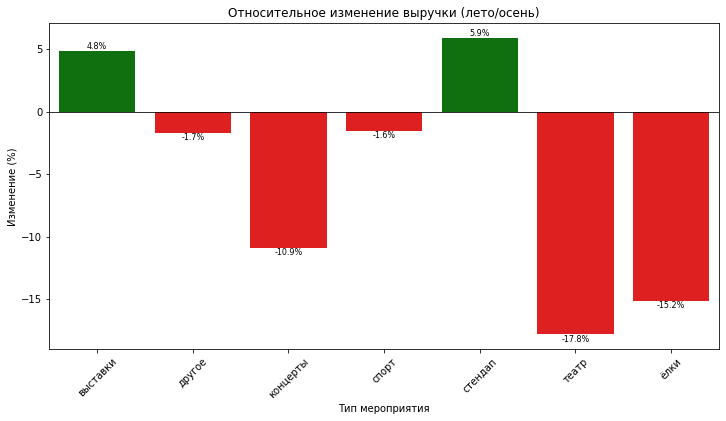

In [54]:
# Группировка по типу мероприятия и сезону
ticket_revenue = merged_df.groupby(['event_type_main', 'season'])['one_ticket_revenue_rub'].mean().reset_index()

# Расчет относительного изменения
summer_rev = ticket_revenue[ticket_revenue['season'] == 'лето'].set_index('event_type_main')
autumn_rev = ticket_revenue[ticket_revenue['season'] == 'осень'].set_index('event_type_main')
relative_change = ((autumn_rev['one_ticket_revenue_rub'] - summer_rev['one_ticket_revenue_rub']) / summer_rev['one_ticket_revenue_rub']) * 100

# Визуализация средних значений с подписями
plt.figure(figsize=(12, 6))
ax1 = sns.barplot(data=ticket_revenue, x='event_type_main', y='one_ticket_revenue_rub', hue='season', palette=['skyblue', 'orange'])
plt.title('Средняя выручка с билета по типам мероприятий')
plt.xlabel('Тип мероприятия')
plt.ylabel('Выручка (руб.)')
plt.xticks(rotation=45)

# Добавляем подписи
for p in ax1.patches:
    ax1.annotate(
        f'{p.get_height():.1f} руб.', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', 
        va='bottom' if p.get_height() > 0 else 'top', 
        color='black',
        fontsize=8
    )
plt.show()

# Создаем список цветов в зависимости от знака изменения
colors = ['green' if val >= 0 else 'red' for val in relative_change.values]

# Визуализация относительного изменения с подписями
plt.figure(figsize=(12, 6))
ax2 = sns.barplot(
    x=relative_change.index,
    y=relative_change.values,
    palette=colors
)
plt.title('Относительное изменение выручки (лето/осень)')
plt.xlabel('Тип мероприятия')
plt.ylabel('Изменение (%)')
plt.axhline(0, color='black', linewidth=0.8)

# Добавляем подписи
for p in ax2.patches:
    ax2.annotate(
        f'{p.get_height():.1f}%', 
        (p.get_x() + p.get_width() / 2, p.get_height()), 
        ha='center', 
        va='bottom' if p.get_height() > 0 else 'top', 
        color='black',
        fontsize=8
    )

plt.xticks(rotation=45)
plt.show()

#### Выручка с билета
На графике выше видно, что выручка с продажи одного билета на такие типы мероприятий, как концерты, театры и ёлки (видимо, берут по акции) летом выше, чем осенью.
Выручка с одного билета за исследуемый период осенью выросла на выставки (+5,4%) и на стендапы (+10,1%). Остальные типы мероприятий показывают минус. Больше всего театры (-17,7%), ёлки (-15,2%) и концерты (-10,1%).

### 3.2. Осенняя активность пользователей

In [55]:
autumn_data = merged_df[merged_df['season'] == 'осень']
# Создание сводной таблицы по дням
daily_stats = autumn_data.groupby('created_dt_msk').agg(
    orders_count=('order_id', 'count'),
    unique_users=('user_id', 'nunique')
).reset_index()
display(daily_stats)

,created_dt_msk,orders_count,unique_users
0,2024-09-01,1331,565
1,2024-09-02,1380,574
2,2024-09-03,5114,778
3,2024-09-04,1774,686
4,2024-09-05,1945,740
...,...,...,...
56,2024-10-27,2854,1036
57,2024-10-28,2841,985
58,2024-10-29,2842,999
59,2024-10-30,2930,1040


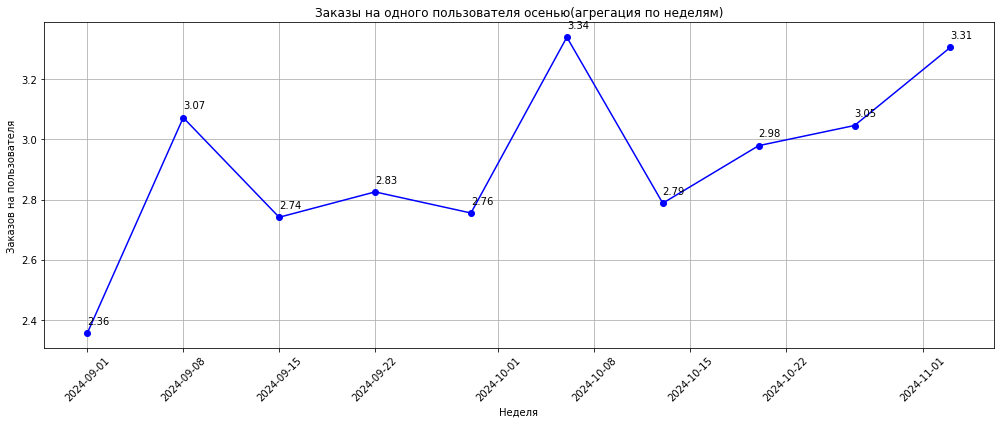

In [56]:
# Расчет заказов на пользователя
daily_stats['orders_per_user'] = daily_stats['orders_count'] / daily_stats['unique_users']

# Агрегация по неделям
weekly_stats = daily_stats.resample('W', on='created_dt_msk').agg({
    'orders_count': 'sum',
    'unique_users': 'sum',
    'orders_per_user': 'mean'
}).reset_index()

# Визуализация линейного графика
plt.figure(figsize=(14, 6))
plt.plot(weekly_stats['created_dt_msk'], weekly_stats['orders_per_user'], 
         marker='o', linestyle='-', color='blue')
plt.title('Заказы на одного пользователя осенью(агрегация по неделям)')
plt.xlabel('Неделя')
plt.ylabel('Заказов на пользователя')

# Добавление подписей значений на график
for x, y in zip(weekly_stats['created_dt_msk'], weekly_stats['orders_per_user']):
    plt.annotate(f'{y:.2f}', (x, y+0.03), textcoords="data")

plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На графике видно, что значительных изменений кол-ва заказов на 1 пользователя не наблюдается. Данные варьируются от 2.4 до 3.3 заказа на 1 пользователя.

In [57]:
# Создание сводной таблицы по дням
daily_stats = autumn_data.groupby('created_dt_msk').agg(
    orders_count=('order_id', 'count'),                        # Общее число заказов
    dau=('user_id', 'nunique'),                                # DAU (уникальные пользователи)
    avg_ticket_price=('price_one_ticket', 'mean')              # Средняя стоимость 1 билета в рублях
).reset_index()

Анализ динамики изменений по дням за сентябрь - октябрь 2024 года


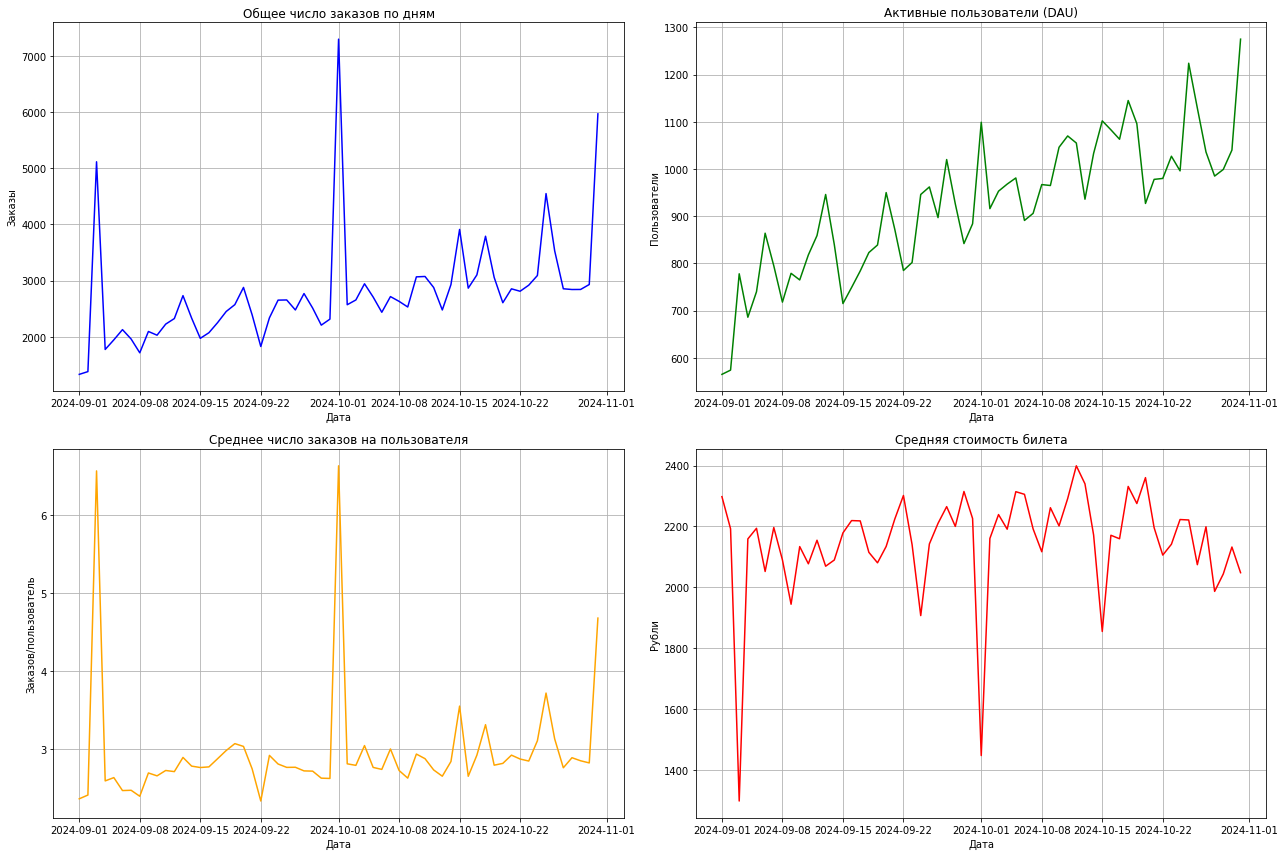

In [58]:
# Расчет среднего числа заказов на пользователя
daily_stats['orders_per_users'] = daily_stats['orders_count'] / daily_stats['dau']

# Визуализация всех метрик на одном графике (4 субплотов)
plt.figure(figsize=(18, 12))

# График 1: Общее число заказов
plt.subplot(2, 2, 1)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='orders_count', color='blue')
plt.title('Общее число заказов по дням')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid(True)

# График 2: DAU
plt.subplot(2, 2, 2)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='dau', color='green')
plt.title('Активные пользователи (DAU)')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.grid(True)

# График 3: Заказы на пользователя
plt.subplot(2, 2, 3)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='orders_per_users', color='orange')
plt.title('Среднее число заказов на пользователя')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователь')
plt.grid(True)

# График 4: Средняя стоимость билета
plt.subplot(2, 2, 4)
sns.lineplot(data=daily_stats, x='created_dt_msk', y='avg_ticket_price', color='red')
plt.title('Средняя стоимость билета')
plt.xlabel('Дата')
plt.ylabel('Рубли')
plt.grid(True)

plt.tight_layout()
print('Анализ динамики изменений по дням за сентябрь - октябрь 2024 года')

plt.show()

/tmp/ipykernel_341/2946158023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autumn_data['day_type'] = autumn_data['created_dt_msk'].dt.dayofweek.apply(lambda x: 'выходной' if x >= 5 else 'будний').copy()


Анализ динамики изменений по будним дням и выходным за период сен.-окт.2024


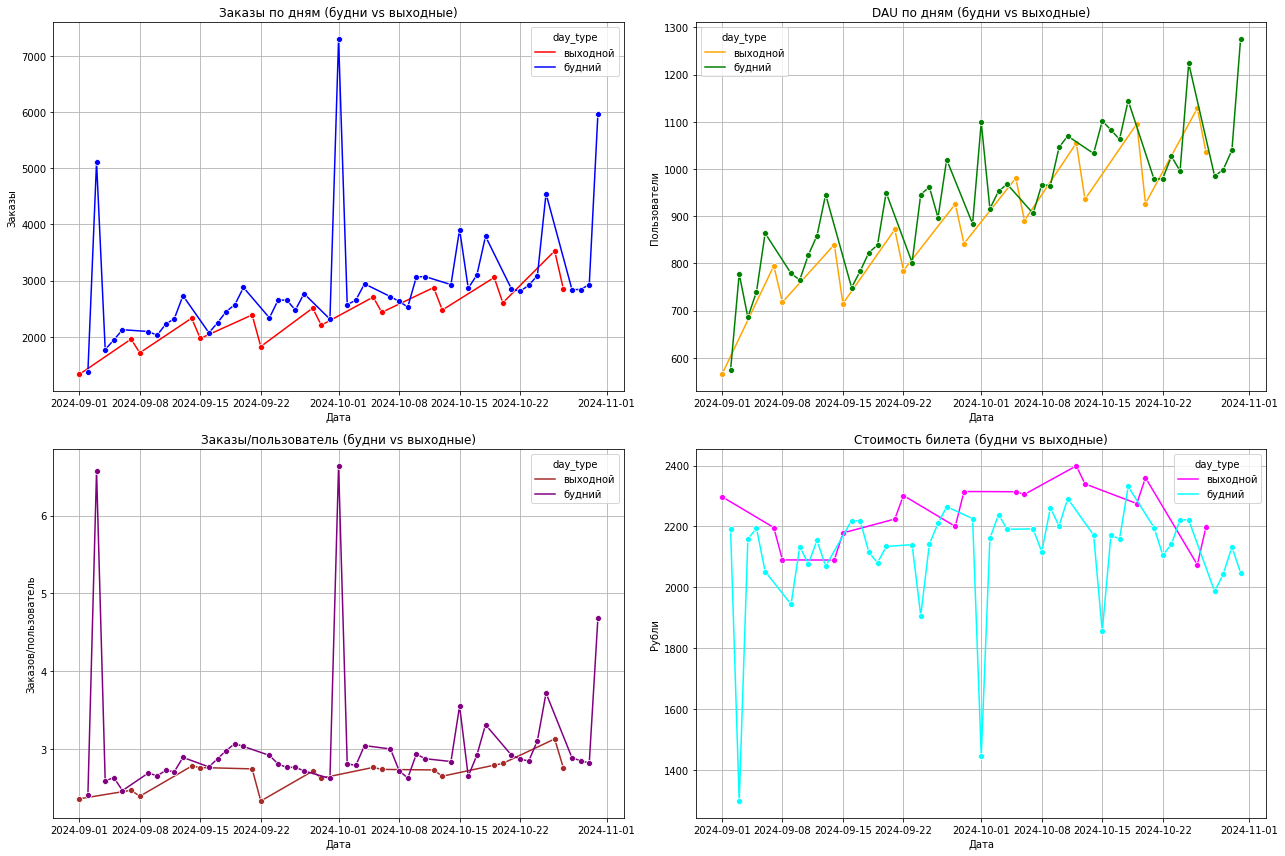

In [59]:
# Добавляем столбец с типом дня (будни/выходные)
autumn_data['day_type'] = autumn_data['created_dt_msk'].dt.dayofweek.apply(lambda x: 'выходной' if x >= 5 else 'будний').copy()

# Создаем сводную таблицу по дням
daily_stats = autumn_data.groupby(['created_dt_msk', 'day_type']).agg(
    orders_count=('order_id', 'count'),              # Общее число заказов
    dau=('user_id', 'nunique'),                      # DAU
    avg_ticket_price=('price_one_ticket', 'mean')         # Средняя стоимость 1 билета
).reset_index()

# Расчет среднего числа заказов на пользователя
daily_stats['orders_per_users'] = daily_stats['orders_count'] / daily_stats['dau']

# Визуализация с разделением на будни/выходные
plt.figure(figsize=(18, 12))

# График 1: Общее число заказов
plt.subplot(2, 2, 1)
sns.lineplot(
    data=daily_stats, 
    x='created_dt_msk', 
    y='orders_count', 
    hue='day_type',
    palette={'будний': 'blue', 'выходной': 'red'},
    marker='o'
)
plt.title('Заказы по дням (будни vs выходные)')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.grid(True)

# График 2: DAU
plt.subplot(2, 2, 2)
sns.lineplot(
    data=daily_stats, 
    x='created_dt_msk', 
    y='dau', 
    hue='day_type',
    palette={'будний': 'green', 'выходной': 'orange'},
    marker='o'
)
plt.title('DAU по дням (будни vs выходные)')
plt.xlabel('Дата')
plt.ylabel('Пользователи')
plt.grid(True)

# График 3: Заказы на пользователя
plt.subplot(2, 2, 3)
sns.lineplot(
    data=daily_stats, 
    x='created_dt_msk', 
    y='orders_per_users', 
    hue='day_type',
    palette={'будний': 'purple', 'выходной': 'brown'},
    marker='o'
)
plt.title('Заказы/пользователь (будни vs выходные)')
plt.xlabel('Дата')
plt.ylabel('Заказов/пользователь')
plt.grid(True)

# График 4: Средняя стоимость билета
plt.subplot(2, 2, 4)
sns.lineplot(
    data=daily_stats, 
    x='created_dt_msk', 
    y='avg_ticket_price', 
    hue='day_type',
    palette={'будний': 'cyan', 'выходной': 'magenta'},
    marker='o'
)
plt.title('Стоимость билета (будни vs выходные)')
plt.xlabel('Дата')
plt.ylabel('Рубли')
plt.grid(True)

plt.tight_layout()

print('Анализ динамики изменений по будним дням и выходным за период сен.-окт.2024')
plt.show()

#### Скачки роста количества заказов Осенью
На графиках за 2 осенних месяца видны ярко выраженные скачки роста количества заказов (1 и 3 график), обусловленные, видимо, снижением стоимости билетов в эти же будние дни (4 график). При этом количество активных пользователей (DAU) стабильно растет, но без ярко выраженных изменений.

### 3.3. Популярные события и партнёры

In [60]:
# Группировка по регионам
region_stats = autumn_data.groupby('region_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count')
).reset_index()

display(region_stats)

# Расчет долей
total_events = region_stats['unique_events'].sum()  # Суммирование значений в знаменателе добавлено
total_all_orders = region_stats['total_orders'].sum()  # Суммирование значений в знаменателе добавлено

,region_name,unique_events,total_orders
0,белоярская_область,44,132
1,берестовский_округ,25,322
2,берёзовская_область,42,348
3,боровлянский_край,76,1240
4,верховинская_область,6,30
...,...,...,...
74,шанырский_регион,17,658
75,широковская_область,803,8715
76,яблоневская_область,432,4199
77,ягодиновская_область,93,662


In [61]:
region_stats['event_share'] = (region_stats['unique_events'] / total_events * 100).round(2)
region_stats['order_share'] = (region_stats['total_orders'] / total_all_orders * 100).round(2)

Популярные регионы с количеством мероприятий и общим числом заказов


,region_name,unique_events,total_orders,event_share,order_share
23,каменевский_регион,3914,46723,24.65,27.67
59,североярская_область,2613,20726,16.45,12.28
41,медовская_область,369,12045,2.32,7.13
75,широковская_область,803,8715,5.06,5.16
44,озернинский_край,296,7526,1.86,4.46
56,светополянский_округ,764,4779,4.81,2.83
40,малиновоярский_округ,137,4546,0.86,2.69
60,серебринская_область,456,4470,2.87,2.65
63,солнечноземская_область,403,4232,2.54,2.51
76,яблоневская_область,432,4199,2.72,2.49


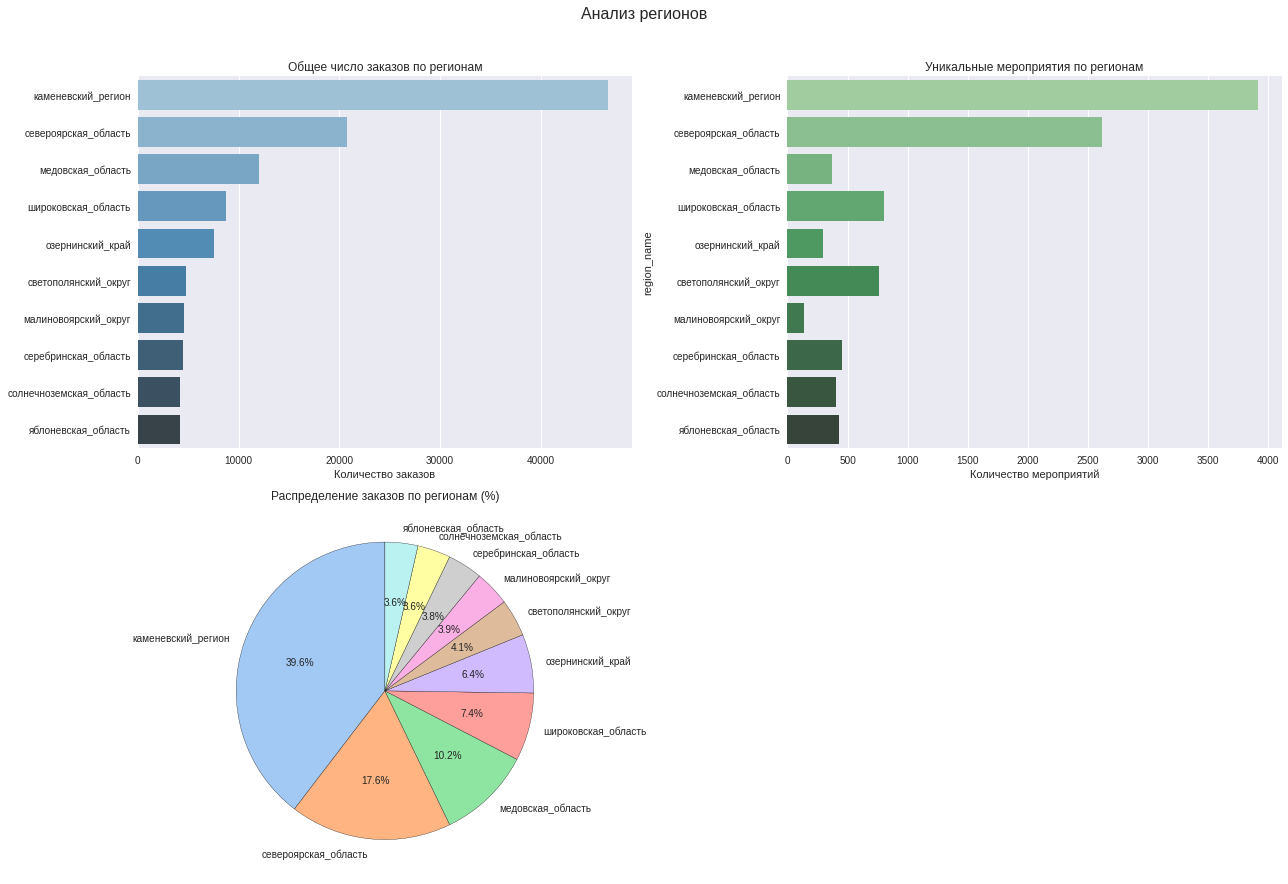

In [62]:
# Результат
print('Популярные регионы с количеством мероприятий и общим числом заказов')
display(region_stats.sort_values(by='total_orders', ascending=False).head(10))

# Сортируем данные для визуализации
region_stats_sorted = region_stats.sort_values(by='total_orders', ascending=False).head(10)

# Настройка стиля
plt.style.use('seaborn')
plt.figure(figsize=(18, 12))
plt.suptitle('Анализ регионов', y=1.02, fontsize=16)

# График 1: Топ-10 регионов по заказам
plt.subplot(2, 2, 1)
ax1 = sns.barplot(
    y='region_name',
    x='total_orders',
    data=region_stats_sorted,
    palette='Blues_d',
    orient='h'
)
plt.title('Общее число заказов по регионам')
plt.xlabel('Количество заказов')
plt.ylabel('')

# График 2: Топ-10 регионов по мероприятиям
plt.subplot(2, 2, 2)
ax2 = sns.barplot(
    y='region_name',
    x='unique_events',
    data=region_stats_sorted,
    palette='Greens_d',
    orient='h'
)
plt.title('Уникальные мероприятия по регионам')
plt.xlabel('Количество мероприятий')

# График 3: Доли заказов
plt.subplot(2, 2, 3)
plt.pie(
    region_stats_sorted['order_share'],
    labels=region_stats_sorted['region_name'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Распределение заказов по регионам (%)')

plt.tight_layout()
plt.show()

In [63]:
# Группировка по партнерам
partner_stats = autumn_data.groupby('service_name').agg(
    unique_events=('event_id', 'nunique'),
    total_orders=('order_id', 'count'),
    total_revenue=('revenue_rub', 'sum')
).reset_index()

# Расчет долей
total_revenue_all = merged_df['revenue_rub'].sum()

partner_stats['event_share'] = (partner_stats['unique_events'] / total_events * 100).round(2)
partner_stats['order_share'] = (partner_stats['total_orders'] / total_all_orders * 100).round(2)
partner_stats['revenue_share'] = (partner_stats['total_revenue'] / total_revenue_all * 100).round(2)

Популярные билетные партнёры с количеством мероприятий и общим числом заказов


,service_name,unique_events,total_orders,total_revenue,event_share,order_share,revenue_share
3,билеты_без_проблем,2848,32541,12525282.65,17.93,19.27,8.40
24,мой_билет,1005,19421,10858727.07,6.33,11.50,7.28
25,облачко,1409,15478,10611051.69,8.87,9.17,7.12
21,лови_билет!,3618,25806,10413065.41,22.78,15.29,6.99
8,весь_в_билетах,600,9427,9379748.64,3.78,5.58,6.29
5,билеты_в_руки,2469,25731,7621225.80,15.55,15.24,5.11
19,край_билетов,193,3005,3039285.48,1.22,1.78,2.04
34,яблоко,537,3473,2763332.31,3.38,2.06,1.85
26,прачечная,728,5798,2548310.47,4.58,3.43,1.71
30,тебе_билет!,859,3766,2181782.10,5.41,2.23,1.46


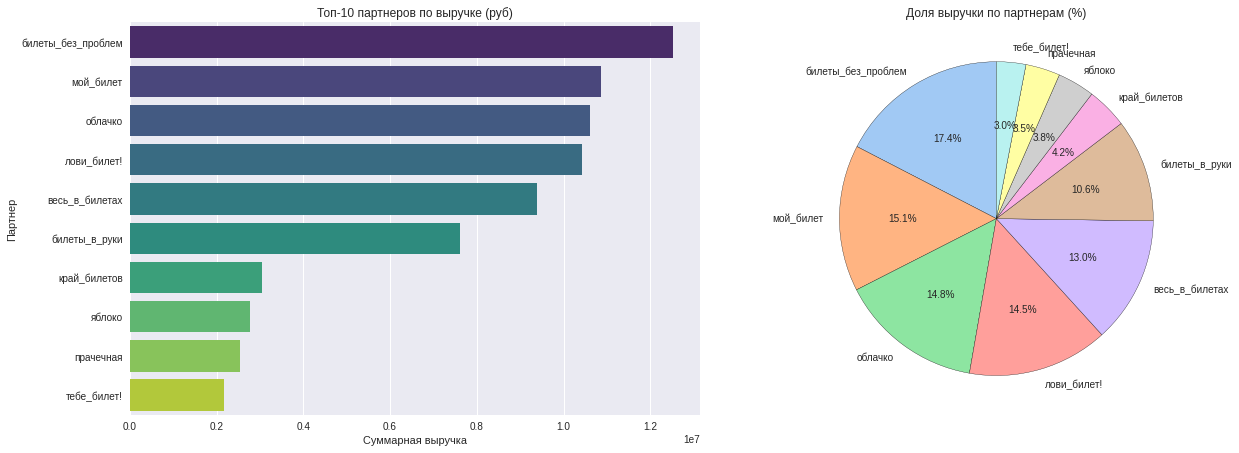

In [64]:
# Округление поля total_revenue
partner_stats['total_revenue'] = partner_stats['total_revenue'].round(2)

# Результат
print('Популярные билетные партнёры с количеством мероприятий и общим числом заказов')
display(partner_stats.sort_values(by='total_revenue', ascending=False).head(10))

# Сортировка по выручке
partner_stats_sorted = partner_stats.sort_values(by='total_revenue', ascending=False).head(10)

# Визуализация
plt.figure(figsize=(18, 12))

# График 1: Топ-10 партнеров по выручке
plt.subplot(2, 2, 1)
sns.barplot(
    data=partner_stats_sorted,
    x='total_revenue',
    y='service_name',
    palette='viridis',
    orient='h'
)
plt.title('Топ-10 партнеров по выручке (руб)')
plt.xlabel('Суммарная выручка')
plt.ylabel('Партнер')

# График 2: Доли выручки
plt.subplot(2, 2, 2)
plt.pie(
    partner_stats_sorted['revenue_share'],
    labels=partner_stats_sorted['service_name'],
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette('pastel'),
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Доля выручки по партнерам (%)')

plt.tight_layout()
plt.show()

**Промежуточный вывод**

Анализ данных показывает, что как среди регионов, так и среди билетных партнёров существуют явные лидеры. 

**Популярные регионы**
Каменевский регион занимает первое место по количеству мероприятий (3946) и общему числу заказов (47514), что составляет 17.59% и 16.35% от общего числа соответственно. Это указывает на высокую активность в данном регионе.
Североярская область находится на втором месте по числу мероприятий (2622) и заказов (20897), что составляет 11.69% и 7.19% соответственно.
Медовская область имеет значительно меньшее количество мероприятий (369), но высокий показатель общего числа заказов (12049), что составляет 1.65% и 4.15% соответственно.

**Популярные билетные партнёры**
“лови_билет!” лидирует по количеству мероприятий (3626) и общему числу заказов (25871), что составляет 16.17% и 8.90% соответственно. Это свидетельствует о высокой популярности данного билетного партнёра.
“билеты_без_проблем” занимает второе место по числу мероприятий (2855) и заказов (32788), что составляет 12.73% и 11.28% соответственно.
“мой_билет” имеет 1012 мероприятий и 19679 заказов, что составляет 4.51% и 6.77% соответственно, и занимает третье место по общему числу заказов.

**Общее распределение данных**
Каменевский регион и “лови_билет!” выделяются как явные лидеры среди регионов и билетных партнёров соответственно.
Североярская область и “билеты_без_проблем” также являются значимыми участниками, занимая высокие позиции по количеству мероприятий и заказов.
Медовская область и “мой_билет” показывают, что даже с меньшим количеством мероприятий можно иметь значительное влияние на общее число заказов.

Таким образом, можно сделать вывод, что распределение данных между категориями неравномерно, и несколько регионов и билетных партнёров доминируют на рынке.

## 4. Статистический анализ данных за осенний период

Проверим 1 гипотезу, которая предполагают большую активность пользователей мобильных устройств:

- Альтернативная гипотеза $H_1: \mu_{\text{Mobile}} > \mu_{\text{Desktop}}$ <br> Среднее **количество заказов** на одного пользователя мобильного приложения **выше** по сравнению с пользователями стационарных устройств.
    
- Нулевая гипотеза $H_0: \mu_{\text{Mobile}} \leq \mu_{\text{Desktop}}$ <br> Среднее **количество заказов** на одного пользователя мобильного приложения **НЕ выше** по сравнению с пользователями стационарных устройств.

In [65]:
# Собираем уникальных пользователей для каждого устройства
mobile_users = set(autumn_data[autumn_data['device_type_canonical'] == 'mobile']['user_id'].unique())
desktop_users = set(autumn_data[autumn_data['device_type_canonical'] == 'desktop']['user_id'].unique())
   
# Вычисляем пересечения и уникальные группы
mixed_users = mobile_users & desktop_users
only_mobile = mobile_users - desktop_users
only_desktop = desktop_users - mobile_users
    
result = {
        'Только мобильные': len(only_mobile),
        'Только десктоп': len(only_desktop),
        'Оба устройства': len(mixed_users),
        'Всего уникальных пользователей': len(mobile_users | desktop_users)
}
    
print(f"Распределение пользователей (n={result['Всего уникальных пользователей']}):")
print(f"• Только мобильные: {result['Только мобильные']} ({result['Только мобильные']/result['Всего уникальных пользователей']:.1%})")
print(f"• Только десктоп: {result['Только десктоп']} ({result['Только десктоп']/result['Всего уникальных пользователей']:.1%})")
print(f"• Используют оба: {result['Оба устройства']} ({result['Оба устройства']/result['Всего уникальных пользователей']:.1%})")


Распределение пользователей (n=15821):
• Только мобильные: 10948 (69.2%)
• Только десктоп: 1623 (10.3%)
• Используют оба: 3250 (20.5%)


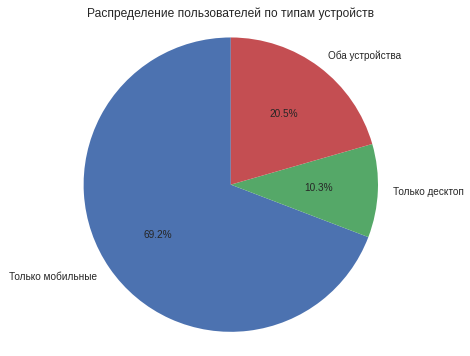

In [66]:
labels = ['Только мобильные', 'Только десктоп', 'Оба устройства']
sizes = [result['Только мобильные'], 
        result['Только десктоп'], 
        result['Оба устройства']]
    
plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Распределение пользователей по типам устройств')
plt.show()

In [67]:
# Расчитаем среднее количество заказов на пользователя:
# Для анализа оставим только тех, кто кто пользуется одним устройством.

# Получаем пользователей с обоими типами устройств
mobile_users = set(autumn_data[autumn_data['device_type_canonical'] == 'mobile']['user_id'])
desktop_users = set(autumn_data[autumn_data['device_type_canonical'] == 'desktop']['user_id'])
mixed_users = mobile_users & desktop_users
    
# Убираем пользователей обоих групп
filtered_df = autumn_data[~autumn_data['user_id'].isin(mixed_users)]

count    12571.000000
mean         2.744809
std          3.989618
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
95%          8.000000
99%         19.000000
max        123.000000
Name: order_count, dtype: float64

Общее число пользователей для каждого устройства total_users ->


,device_type_canonical,total
0,desktop,1614
1,mobile,10836


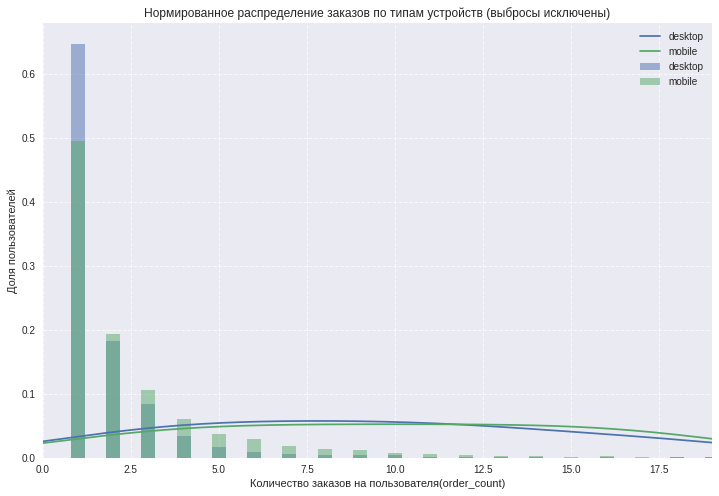

In [68]:
# Рассмотрим распределение количества заказов на пользователя по типам устройств
# Группируем данные по девайсам и пользователям
grouped = filtered_df.groupby(['device_type_canonical','user_id']).size().reset_index(name='order_count')
display(grouped['order_count'].describe(percentiles=[0.25,0.5,0.75,0.95,0.99]))

max_orders = grouped.groupby('device_type_canonical')['order_count'].transform('max')
grouped['normalized_count'] = grouped['order_count'] / max_orders

# Находим 99-й процентиль заказов (т.к. есть выбросы)
order_percentile = grouped['order_count'].quantile(0.99)

# Фильтруем строки ниже 99-го процентиля
low_order_count = grouped[grouped['order_count'] <= order_percentile].copy()

# Считаем пользователей по кол-ву заказов
counts = low_order_count.groupby(['device_type_canonical', 'order_count']).agg(
    count=('user_id', 'count')
).reset_index()

# Считаем общее число пользователей для каждого устройства
total_users = low_order_count.groupby('device_type_canonical').agg(
    total=('user_id', 'count')
).reset_index()
print('Общее число пользователей для каждого устройства total_users ->')
display(total_users)

# Соединяем данные
counts = counts.merge(total_users, on='device_type_canonical')
counts['proportion'] = counts['count'] / counts['total']

# Строим график без выбросов
plt.figure(figsize=(12, 8))
for device in counts['device_type_canonical'].unique():
    subset = counts[counts['device_type_canonical'] == device]
    plt.bar(
        subset['order_count'], 
        subset['proportion'], 
        alpha=0.5, 
        label=device,
        width=0.4,
        align='center'
    )
    # Добавляем KDE для каждого типа устройства
    sns.kdeplot(subset['order_count'], shade=False, label=device)
    
plt.xlabel('Количество заказов на пользователя(order_count)')
plt.ylabel('Доля пользователей')
plt.title('Нормированное распределение заказов по типам устройств (выбросы исключены)')
plt.xlim([0, max(subset['order_count'])])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

По графику видно, что основная масса пользователей оформляют не более 3 заказаов. При этом, десктоп-пользователи в большинстве своем оформляют 1 заказ, а 2 и более больше мобильные пользователи. Т.к. в данных имеется выброс - max 123 заказа - оставляем для анализа и визуализации данные до 99 процентиля.

Для проверки равномерности распределения пользователей по устройствам предполагаем, что участники распределены равномерно.

Нулевая гипотеза (H0):
Распределение активности пользователей по устройствам является равномерным. То есть вероятность попадания пользователя в любую из групп одинакова: 

**H0: $X \sim  $ Discrete Uniform(А,В)**

Альтернативная гипотеза (H1):
Распределение активности пользователей по устройствам не является равномерным. То есть существует статистически значимое отклонение от равномерного распределения: 

**H1: $X \not\sim  $ Discrete Uniform(А,В)**

In [69]:
# Группируем данные по устройствам и считаем количество заказов
group_counts = (
    filtered_df.groupby('device_type_canonical')['order_id']
    .count()
    .reset_index()
    .rename(columns={
        'order_id': 'count', 
        'device_type_canonical': 'device_type'
    })
)
print("Распределение общего кол-ва заказов по устройствам:")
print(group_counts)

# Проводим тест хи-квадрат на равномерность распределения
total_orders = group_counts['count'].sum()
expected = [total_orders / 2] * 2  # Ожидаемое равномерное распределение

# Упорядочиваем значения по алфавиту (desktop, mobile)
observed = group_counts.sort_values('device_type')['count'].values

chi2, p = stats.chisquare(f_obs=observed, f_exp=expected)

print(f"\nХи-квадрат: {chi2:.3f}")
print(f"p-value: {p:.8f}")

alpha = 0.05
if p > alpha:
    print("\nНет доказательств против равномерного распределения (p > 0.05)")
else:
    print("\nРаспределение неравномерно (p ≤ 0.05)")

Распределение общего кол-ва заказов по устройствам:
  device_type  count
0     desktop   3193
1      mobile  31312

Хи-квадрат: 22914.887
p-value: 0.00000000

Распределение неравномерно (p ≤ 0.05)


Поскольку ЦПТ утверждает, что распределение выборочных средних стремится к нормальному распределению при достаточно большом размере выборки (в нашем случае n зачительно ≥ 30),  применение t-теста все же недопустимо из-за того, что данные имеют тяжёлые хвосты или выбросы, что видно на графике выше. 

Применим Тест Манна-Уитни. 

In [70]:
# ГИПОТЕЗА № 1:Среднее количество заказов на одного пользователя мобильного приложения выше 
#              по сравнению с пользователями стационарных устройств.
mobile = low_order_count[low_order_count['device_type_canonical'] == 'mobile']['order_count'].copy()
desktop = low_order_count[low_order_count['device_type_canonical'] == 'desktop']['order_count'].copy()

print('Статистика order_count после фильтрации:')
grouped_by_device = low_order_count.groupby('device_type_canonical')
# Выводим количество заказов по типам устройств
for device_type_canonical, order_count in grouped_by_device:
    print(f"Тип устройства: {device_type_canonical}")
    print(order_count[['order_count']].describe())
    print("\n")

# Проведем тест Манна-Уитни
# Альтернативная гипотеза: Медиана заказов мобильных пользователей > Медиана заказов десктоп-пользователей
result_U = mannwhitneyu(mobile, desktop, alternative='greater')

# Выводим результаты
print('')
print(f"Медиана заказов мобильных пользователей: {np.median(mobile)}")
print(f"Медиана заказов десктоп-пользователей: {np.median(desktop)}")
print('')
print(f"p-value теста Манна-Уитни: {result_U.pvalue}")
print('')

alpha = 0.05  # уровень значимости

# Интерпретация результатов теста
if result_U.pvalue < alpha:
    print(f'Гипотеза подтверждается p-value = {round(result_U.pvalue,5)}: количество заказов на одного мобильно пользователя больше, чем на десктоп.')
else:
    print("Нет достаточных оснований для подтверждения гипотезы")

Статистика order_count после фильтрации:
Тип устройства: desktop
       order_count
count  1614.000000
mean      1.791202
std       1.704564
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max      19.000000


Тип устройства: mobile
        order_count
count  10836.000000
mean       2.576597
std        2.640940
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       19.000000



Медиана заказов мобильных пользователей: 2.0
Медиана заказов десктоп-пользователей: 1.0

p-value теста Манна-Уитни: 3.342468440104565e-39

Гипотеза подтверждается p-value = 0.0: количество заказов на одного мобильно пользователя больше, чем на десктоп.


Проверим 2 гипотезу, которая предполагают большую активность пользователей мобильных устройств:
    
- Альтернативная гипотеза $H_1: \mu_{\text{Mobile}} > \mu_{\text{Desktop}}$ <br> **Среднее время между заказами** пользователей мобильных приложений **выше** по сравнению с пользователями стационарных устройств.
    
- Нулевая гипотеза $H_0: \mu_{\text{Mobile}} \leq \mu_{\text{Desktop}}$ <br> **Среднее время между заказами** пользователей мобильных приложений **НЕ выше** по сравнению с пользователями стационарных устройств.

In [71]:
# Проанализируем количеством дней с предыдущей покупки
print(filtered_df['days_since_prev'].describe())

count    26689.000000
mean        14.126607
std         26.347548
min          0.000000
25%          0.000000
50%          1.000000
75%         15.000000
max        148.000000
Name: days_since_prev, dtype: float64


In [72]:
grouped_by_device = filtered_df.groupby('device_type_canonical')
# Выводим выручку и количество дней по типам устройств
for device_type_canonical, days_since_prev in grouped_by_device:
    print(f"Тип устройства: {device_type_canonical}")
    print(days_since_prev[['revenue_rub', 'days_since_prev']].describe())
    print("\n")

Тип устройства: desktop
       revenue_rub  days_since_prev
count  3193.000000      2070.000000
mean    514.361295        18.165216
std     489.544331        32.743252
min       0.000000         0.000000
25%     143.480000         0.000000
50%     336.400000         0.000000
75%     748.670000        23.000000
max    2596.670000       146.000000


Тип устройства: mobile
        revenue_rub  days_since_prev
count  31312.000000     24619.000000
mean     476.317506        13.787034
std      493.956923        25.709379
min      -10.770000         0.000000
25%       87.290034         0.000000
50%      298.760000         1.000000
75%      727.450000        15.000000
max     2617.720000       148.000000




In [73]:
# Посмотрим среднее значение без учета заказов пользователей, которые совершили первую покупку (предыдущей не было).
# Группируем данные по устройствам и считаем среднее кол-во дней
group_counts = (
    filtered_df[filtered_df['days_since_prev'] > 0].groupby('device_type_canonical')['days_since_prev']
    .mean()
    .reset_index()
    .rename(columns={
        'days_since_prev': 'avg_days', 
        'device_type_canonical': 'device_type'
    })
)
print("Среднее кол-во дней между заказами по устройствам:")
print(group_counts)

Среднее кол-во дней между заказами по устройствам:
  device_type   avg_days
0     desktop  47.179424
1      mobile  26.610975


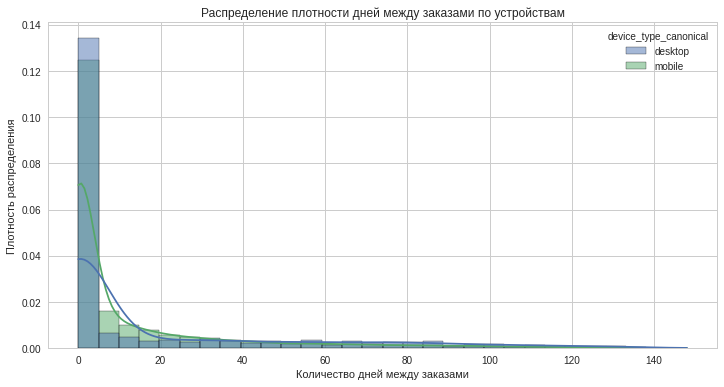

In [74]:
# Настройки отображения
plt.rcParams['figure.figsize'] = [12, 6]  
plt.style.use('seaborn-whitegrid')  

# Получаем уникальные девайсы
device = filtered_df['device_type_canonical'].unique()

# Используем sns.histplot 
sns.histplot(
    data = filtered_df,
    x = 'days_since_prev',
    hue = 'device_type_canonical',
    hue_order = device,
    stat = 'density', 
    common_norm = False,  # каждая группа нормируется отдельно
    kde = True,  
    bins = 30
)

plt.title('Распределение плотности дней между заказами по устройствам')
plt.xlabel('Количество дней между заказами')
plt.ylabel('Плотность распределения')
plt.show()

Большинство как десктоп-заказов, так и мобильных заказов имеют время между заказами 0 дней (повторные покупки в тот же день).
Максимальное время между заказами: ~5 месяцев (146-148 дней).

Согласно ЦПТ, распределение выборочных средних стремится к нормальному распределению при достаточно большом размере выборки (в нашем случае n зачительно ≥ 30),  применение t-теста все же недопустимо из-за того, что данные имеют тяжёлые хвосты или выбросы, что видно на графике выше. 

Применим Тест Манна-Уитни. 

In [75]:
# ГИПОТЕЗА 2: Среднее время между заказами пользователей мобильных приложений выше 
#              по сравнению с пользователями стационарных устройств.

# Фильтруем пользователей с ≥2 заказами и кол-ом дней между заказами больше 0
filtered_users = filtered_df.groupby(['device_type_canonical', 'user_id']).filter(
    lambda x: (len(x) >= 2) & 
               (x['days_since_prev'] > 0).all() & 
               (x['days_since_prev'].notnull().all())
)

# Расчет среднего времени между заказами
df_grouped = filtered_users.groupby(['device_type_canonical', 'user_id']).agg(
    avg_days=('days_since_prev', 'mean'), 
    order_count=('order_id', 'count')
).reset_index()

mobile = df_grouped[df_grouped['device_type_canonical'] == 'mobile']['avg_days'].copy()
desktop = df_grouped[df_grouped['device_type_canonical'] == 'desktop']['avg_days'].copy()

# Выводим результаты
print(f"Медиана кол-ва дней м/у заказами десктоп-пользователей: {np.median(desktop)}")
print(f"Медиана кол-ва дней м/у заказами мобильных пользователей: {np.median(mobile)}")
print('')

p = stats.mannwhitneyu(mobile, desktop, alternative='greater')

alpha = 0.05  # уровень значимости

# Интерпретация результатов теста
if p.pvalue < alpha:
    print(f'Гипотеза подтверждается p-value = {round(p.pvalue,5)}: Среднее время м/у заказами у мобильных пользователей ВЫШЕ, чем со стационарных устройств.')
else:
    print(f'p-value теста Манна-Уитни: {round(p.pvalue,5)}: Нет достаточных оснований для подтверждения гипотезы:')
    print('                     Среднее время м/у заказами у мобильных пользователей НЕ выше, чем со стационарных устройств.')

Медиана кол-ва дней м/у заказами десктоп-пользователей: 33.5
Медиана кол-ва дней м/у заказами мобильных пользователей: 28.5

p-value теста Манна-Уитни: 0.93409: Нет достаточных оснований для подтверждения гипотезы:
                     Среднее время м/у заказами у мобильных пользователей НЕ выше, чем со стационарных устройств.


Вывод: 

1. Распределение пользователей: Мобильные пользователи доминируют: 69.2% используют только мобильное приложение. Значительная доля смешанных пользователей: 20.5% взаимодействуют с обоими типами устройств. Десктоп-аудитория наименьшая: только 10.3% используют исключительно стационарные устройства.

2. Активность пользователей: 
    - Среднее количество заказов на мобильных пользователей: 2, на десктоп: 1 - мобильные пользователи активнее (на 50% меньше).
    - Статистическая значимость: p-value = 0.0 (гипотеза подтверждена). Распределение заказов крайне неравномерно (χ² = 22914.9). 
    - Время между заказами: Мобильные: 28,5 дня, десктоп: 33,5 дня (на 17,5 % больше). Мобильные пользователи совершают заказы чаще. p-value = 0.93 (гипотеза не подтверждена).

3. Особенности распределений:
    Пиковое поведение: 75% десктоп-заказов и 50% мобильных заказов имеют время между заказами 0 дней (повторные покупки в тот же день). Максимальное время между заказами: ~5 месяцев (146-148 дней).

## 5. Общий вывод и рекомендации

### Информация о данных:

Первый датасет `final_tickets_orders_df.csv` содержит 290 849 строк и 14 столбцов. 

Типы данных корректны. Проведена работа по снижению размерности количественных данных. Два поля преобразованы в тип дата на стадии загрузки:
- `created_dt_msk` — дата создания заказа (московское время).
- `created_ts_msk` — дата и время создания заказа (московское время).
Пропуски в данных отсутствуют, кроме столбца `days_since_prev` - в нем 21 940 пропусков. Значит столько пользователей совершили первую покупку (предыдущей не было) - установлена заглушка с нулем.

Второй датасет `final_tickets_events_df.csv` содержит 22 427 строк и 11 столбцов. Типы данных корректны. Проведена работа по снижению размерности количественных данных. Пропуски отсутствуют.

Вспомогательный датасет `final_tickets_tenge_df.csv` содержит 357 строк и 4 столбца. Типы данных корректны. Проведена работа по снижению размерности количественных данных. Пропуски отсутствуют.

Для корректного анализа на дубликаты проведена работа по удалению пробелов, буквы приведены к единому строчному формату в столбцах, содержащих текстовые данные. Выявлен один город Глинополье, который имеется в двух регионах, и 8 площадок, имеющих разнящиеся id и адреса.

Анализ показал наличие 30 строк с неявными дубликатами по бронированию билетов в рублях. Данные строки удалены из датафрейма.

Анализ заказов в рублях показал, что в заказах присутствуют аномальные значения. Имеется ряд возвратов, т.к. min значение равно -90.76 руб., а так же, видимо, разовая акция покупки 57 билетов и покупки на максимальную сумму 81 174.54 руб.

Если исключить аномальные значения, кол-во купленных билетов и выручка с заказа, оформленного в рублях, не сильно отличаются при оформлении с различных устройств. 
При анализе покупок в тенге аномальных выбросов не выявлено. Данные переведены в рубли по курсу, соответствующему дню заказа.

Сормирован итоговоый датафрейм merged_df - объединенный из 3х первоначальных, со столбцом по выручке в рублях, ценой 1 билета в рублях, временем года, не имеющий выбросов.

### Основные результаты анализа:
Анализ показал, что в целом **с июня по ноябрь заказы выросли** почти в 3 раза (с 33 903 до 99 413). При этом видно, что:

- Летом преобладают концерты и театры, а осенью — спорт и стендап. Ярко выражены отличия по концертам (больше летом) и спорту (больше осенью). 
- Устройства используются практически одинаково, мобильные устройства чуть чаще летом, а стационарные - осенью.
- Посещение мероприятий в возрасте 6 и 12 лет практически одинаково в оба сезона. Однако, на мероприятия с возрастным ограничением 16+, 18+ чаще покупают билеты летом, а 0+ - осенью.

**Выручка с продажи одного билета** на такие типы мероприятий, как концерты, театры и ёлки (видимо, берут по акции) летом выше, чем осенью.
Выручка с одного билета за исследуемый период осенью выросла на выставки (+5,4%) и на стендапы (+10,1%). Остальные типы мероприятий показывают минус. Больше всего театры (-17,7%), ёлки (-15,2%) и концерты (-10,1%).

На графиках за **2 осенних месяца** видны ярко выраженные **скачки роста** количества заказов (1 и 3 график), обусловленные, видимо, снижением стоимости билетов в эти же будние дни (4 график). При этом количество активных пользователей (DAU) стабильно растет, но без ярко выраженных изменений.

Анализ данных показывает, что как среди регионов, так и среди билетных партнёров существуют явные лидеры. 

**Популярные регионы**
Каменевский регион занимает первое место по количеству мероприятий (3946) и общему числу заказов (47514), что составляет 17.59% и 16.35% от общего числа соответственно. Это указывает на высокую активность в данном регионе.
Североярская область находится на втором месте по числу мероприятий (2622) и заказов (20897), что составляет 11.69% и 7.19% соответственно.
Медовская область имеет значительно меньшее количество мероприятий (369), но высокий показатель общего числа заказов (12049), что составляет 1.65% и 4.15% соответственно.

**Популярные билетные партнёры**
“лови_билет!” лидирует по количеству мероприятий (3626) и общему числу заказов (25871), что составляет 16.17% и 8.90% соответственно. Это свидетельствует о высокой популярности данного билетного партнёра.
“билеты_без_проблем” занимает второе место по числу мероприятий (2855) и заказов (32788), что составляет 12.73% и 11.28% соответственно.
“мой_билет” имеет 1012 мероприятий и 19679 заказов, что составляет 4.51% и 6.77% соответственно, и занимает третье место по общему числу заказов.

**Общее распределение данных**
Каменевский регион и “лови_билет!” выделяются как явные лидеры среди регионов и билетных партнёров соответственно.
Североярская область и “билеты_без_проблем” также являются значимыми участниками, занимая высокие позиции по количеству мероприятий и заказов.
Медовская область и “мой_билет” показывают, что даже с меньшим количеством мероприятий можно иметь значительное влияние на общее число заказов.

Таким образом, можно сделать вывод, что распределение данных между категориями неравномерно, и несколько регионов и билетных партнёров доминируют на рынке.

### Результаты проверки гипотез

Распределение общего числа пользователей по предпочтениям оформления заказа (n=15821):

    • Только мобильные: 10948 (69.2%)
    • Только десктоп: 1623 (10.3%)
    • Используют оба: 3250 (20.5%)

Количество заказов, оформленное через desktop (3193 шт.) значительно ниже, чем через mobile (31 312 шт.).

Для проверка 1 гипотезы, которая предполагает, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств (𝐻1:𝜇Mobile > 𝜇Desktop). Среднее количество заказов на пользователя: desktop - 1, mobile - 2. Проверка нормальности распределения показала, что данные неравномерны, в выборке присутствуют выбросы - используем тест Манна-Уитни, p-value: 0.00000000: гипотеза, что среднее количество заказов на одного пользователя мобильного приложения выше по сравнению с пользователями стационарных устройств, подтверждена.
 
Для проверка 2 гипотезы, которая предполагает, что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств, используем так же тест Манна-Уитни. Т.к. большинство как десктоп-заказов, так и мобильных заказов имеют время между заказами 0 дней (повторные покупки в тот же день), эти данные исключаем из выборки. Так же в выборке имеется выброс - максимальное время между заказами ~5 месяцев (146-148 дней). Гипотеза, что среднее время между заказами пользователей мобильных приложений выше по сравнению с пользователями стационарных устройств, не подтверждена.

**Вывод:** 

1. Распределение пользователей: Мобильные пользователи доминируют: 69.2% используют только мобильное приложение. Значительная доля смешанных пользователей: 20.5% взаимодействуют с обоими типами устройств. Десктоп-аудитория наименьшая: только 10.3% используют исключительно стационарные устройства.

2. Активность пользователей: 
    - Среднее количество заказов на мобильных пользователей: 2, на десктоп: 1 (на 50% меньше). Мобильные пользователи активнее (гипотеза подтверждена).
    - Распределение заказов крайне неравномерно (χ² = 22914.9). 
    - Время между заказами: мобильные: 28,5 дня, десктоп: 33,5 дня (на 17% больше). Мобильные пользователи совершают заказы чаще. p-value = 0.0 (гипотеза не подтверждена).

3. Особенности распределений:    
    Пиковое поведение: 75% десктоп-заказов и 50% мобильных заказов имеют время между заказами 0 дней (повторные покупки в тот же день). Максимальное время между заказами: ~5 месяцев (146-148 дней).

**На основании вышеизложенного, можно кратно сформулировать ответы на поставленные бизнесом вопросы:**

-	*Сработал фактор сезонности и пользователи поменяли предпочтения?* Да, предпочтения меняются в зависимости от сезона.
-	*Изменилась ли аудитория?* Покупка билетов на мероприятия 6+ и 12+ лет практически одинакова в оба сезона. На 16+, 18+ чаще покупают билеты летом, а 0+ - осенью.
-	*Какие события стали привлекать больше зрителей?* Летом преобладают концерты и театры, а осенью — спорт и стендап.
-	*Какие организаторы и площадки выбились в лидеры?*  Каменевский регион и “лови_билет!” выделяются как явные лидеры среди регионов и билетных партнёров соответственно.
-	*Отличаются ли своей активностью пользователи мобильных устройств от клиентов, которые бронируют билеты со стационарного компьютера.* Количество заказов, оформленное через desktop (3193 шт.) значительно ниже, чем через mobile (31 312 шт.). Время между заказами: мобильные: 28,5 дня, десктоп: 33,5 дня (на 17% больше). 

### Рекомендации
1. Сезонное планирование мероприятий и маркетинга.
Летом увеличивать количество концертов и театральных мероприятий, а также продвигать их через таргетированную рекламу для аудитории 16+ и 18+.
Осенью фокусироваться на спортивных событиях, стендапах и семейных мероприятиях (0+), используя тематические промоакции (например, "Семейные выходные").
Для мероприятий с падающей выручкой (театры, ёлки, концерты осенью) внедрять скидки или пакетные предложения.
Использовать "скачки спроса" в будние дни осенью: запускать flash-скидки или бонусы за покупки в эти периоды.
2. Оптимизация мобильного опыта.
Внедрить push-уведомления о новых мероприятиях и акциях для увеличения частоты покупок.
Создать программу лояльности с бонусами за использование мобильного приложения (например, кэшбэк за первый заказ через приложение).
Для пользователей, которые используют оба типа устройств (20.5%), предлагать синхронизацию корзины между десктопом и мобильным приложением.
3. Повышение лояльности десктоп-аудитории.
Стимулы для десктоп-пользователей:
Предлагать уникальные опции на десктоп-версии (например, выбор лучших мест на схеме зала).
Для десктоп-пользователей с большим временем между заказами (~33,5 дня) внедрить email-рассылки с персональными предложениями через 10-15 дней после предыдущей покупки.
4. Укрепление лидеров и развитие регионов.
Усилить партнерство с Каменевским регионом и Североярской областью через эксклюзивные мероприятия или ранний доступ к билетам.
Для Медовской области (высокий спрос при малом количестве мероприятий) увеличить число событий, учитывая локальные предпочтения.
Провести совместные маркетинговые кампании с "лови_билет!" и "билеты_без_проблем", например, кобрендинговые акции.
Для партнеров с низкой активностью предложить аналитику предпочтений аудитории, чтобы помочь в подборе мероприятий.
5. Анализ и предотвращение аномалий.
Установить лимиты на количество билетов в одном заказе для предотвращения спекуляции.
Использовать алгоритмы для автоматического обнаружения аномальных заказов (например, покупки на 5+ месяцев вперед) и их ручной проверки.
Внедрить систему автоматического опроса пользователей при возврате билетов, чтобы выявить причины (например, технические ошибки или недовольство мероприятием).
6. Расширение в тенге.
Учитывая отсутствие аномалий в тенговых заказах и стабильный спрос, проработать экспансию в Казахстан:
Адаптировать маркетинг под локальные предпочтения (например, акценты на популярные в регионе типы мероприятий).
Интегрировать местные способы оплаты.

Реализация этих рекомендаций поможет увеличить выручку, частоту покупок и лояльность аудитории.